In [1]:
!nvidia-smi

Tue Nov 26 12:49:39 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     On  |   00000000:04:00.0 Off |                    0 |
|  0%   61C    P0            201W /  300W |   38951MiB /  46068MiB |     84%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# !pip install onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/\
# !pip install -q git+https://github.com/roboflow/sports.git
# !pip install --upgrade pip setuptools wheel
# !pip install supervision>=0.23.0
# !pip install inference
# !pip install plotly
# # !git clone https://github.com/roboflow/sports.git
# !pip install ultralytics

In [3]:
# Import libraries
import numpy as np
import pandas as pd
import os
import cv2
import skimage
from PIL import Image
from ultralytics import YOLO
from matplotlib import pyplot as plt
import json
import time
import supervision as sv
import random
from tqdm import tqdm

In [4]:
import torch
# Replace 0 with the index of the GPU you want to use
device_number = 3
device = torch.device(f'cuda:{device_number}')

print(f"Using device: {device}")

Using device: cuda:3


In [ ]:
model_path = "/dkucc/home/oe23/Game-State-Reconstruction/ultralytics/runs/detect/train7/weights/best.pt"  # Update if different

BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3

labels_dic = {
    0:"Ball",
    1:"GK",
    2:"Player",
    3:"Referee",
}

model_players = YOLO(model_path, verbose=False, silent=True)
model_players.to(device)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 80, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(80, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(80, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(160, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(400, 160, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(160, eps=0.001, momentum=0.03, affine=True, track_r

In [6]:
# Initialize frame counter
frame_nbr = 0

# Set confidence thresholds for players and field keypoints detections
player_model_conf_thresh = 0.80

# Set variable to record the time when we processed last frame 
prev_frame_time = 0
# Set variable to record the time at which we processed current frame 
new_frame_time = 0

# Store the ball track history
ball_track_history = {'src':[],
                      'dst':[]
}

# Count consecutive frames with no ball detected
nbr_frames_no_ball = 0
# Threshold for number of frames with no ball to reset ball track (frames)
nbr_frames_no_ball_thresh = 30
# Distance threshold for ball tracking (pixels)
ball_track_dist_thresh = 100
# Maximum ball track length (detections)
max_track_length = 35

# Initialize counters and storage for class detections
class_detection_counts = {}

In [7]:
video_path = '/dkucc/home/oe23/football_tracking/C0018_1.MP4'
original_image = cv2.imread('/dkucc/home/oe23/football_tracking/frame.png')

Grass BGR color:  (33.598850721623705, 86.5013691081267, 64.37901022063008)


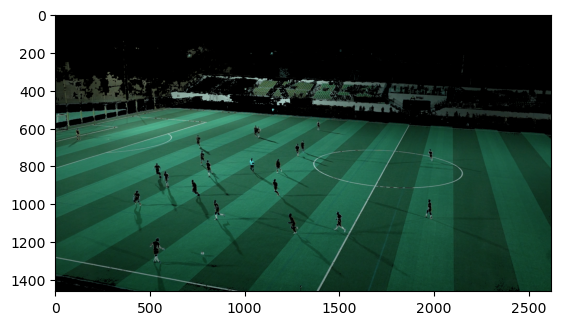

In [8]:
img = original_image
hsv = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)

# Define a large range of green color in HSV
lower_green = np.array([30, 40, 40])
upper_green = np.array([80, 255, 255])

# Threshold the HSV image to get only green colors
mask = cv2.inRange(hsv, lower_green, upper_green)

# Calculate the mean value of the pixels that are not masked
masked_img = cv2.bitwise_and(img, img, mask=mask)
plt.imshow(masked_img)
grass_color = cv2.mean(img, mask=mask)
grass_color = grass_color[:3]
print("Grass BGR color: ", grass_color)

In [9]:
# import cv2
# import numpy as np
# import random
# from tqdm import tqdm
# import os

# # Video path
# video_path = "/dkucc/home/oe23/football_tracking/C0018_1.MP4"

# # Output path for saving crops
# crops_output_folder = "/dkucc/home/oe23/Game-State-Reconstruction/player_crops"
# os.makedirs(crops_output_folder, exist_ok=True)

# # Initialize video capture
# cap = cv2.VideoCapture(video_path)

# # Get total number of frames
# total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# # Model configurations
# player_model_conf_thresh = 0.5  # Example confidence threshold
# num_random_frames = 1000  # Number of random frames to sample

# # Generate 1000 random frame indices
# random_frames = sorted(random.sample(range(total_frames), num_random_frames))

# # Placeholder for bounding boxes, labels, and confidence scores
# all_bboxes = []
# all_labels = []
# all_confs = []

# # Read and process random frames
# crop_count = 0
# for frame_idx in tqdm(random_frames, desc="Processing frames"):
#     # Seek to the specific frame
#     cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
#     ret, img = cap.read()
#     if not ret:
#         print(f"Could not read frame {frame_idx}")
#         continue

#     # Perform detection
#     results_players = model_players(img, conf=player_model_conf_thresh)

#     # Extract detection data
#     bboxes_p = results_players[0].boxes.xyxy.cpu().numpy()
#     labels_p = list(results_players[0].boxes.cls.cpu().numpy())
#     confs_p = list(results_players[0].boxes.conf.cpu().numpy())

#     all_bboxes.append(bboxes_p)
#     all_labels.append(labels_p)
#     all_confs.append(confs_p)

#     # Extract player crops
#     for i, label in enumerate(labels_p):
#         if label == 2:  # Assuming '2' is the label for players
#             x1, y1, x2, y2 = map(int, bboxes_p[i])
#             player_img = img[y1:y2, x1:x2]

#             if player_img.size > 0:  # Ensure the crop is valid
#                 crop_file_path = os.path.join(crops_output_folder, f"crop_{crop_count}.jpg")
#                 cv2.imwrite(crop_file_path, player_img)
#                 crop_count += 1

# # Release video capture
# cap.release()

# print(f"Processed bounding boxes: {len(all_bboxes)}")
# print(f"Saved {crop_count} player crops in {crops_output_folder}.")


In [10]:
import cv2
import numpy as np
from pathlib import Path
from sports.common.team import TeamClassifier 

# Define paths to your dataset
crops_output_folder = "/dkucc/home/oe23/Game-State-Reconstruction/player_crops"
crops_folder = crops_output_folder # Path to folder containing image crops

# Load crops
def load_crops(crops_folder: str):
    """
    Load image crops from the specified folder.

    Args:
        crops_folder (str): Path to the folder containing crops.

    Returns:
        List[np.ndarray]: List of loaded crops as numpy arrays.
    """
    crops = []
    for image_path in Path(crops_folder).glob("*.jpg"):  # Adjust extension if needed
        img = cv2.imread(str(image_path))
        if img is not None:
            crops.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return crops

# Instantiate the classifier
classifier = TeamClassifier(device=device, batch_size=1024)

# Load the crops
print("Loading crops...")
crops = load_crops(crops_folder)
print(f"Loaded {len(crops)} crops.")

# Train the model
print("Training the model...")
classifier.fit(crops)
print("Model training completed.")

Loading crops...
Loaded 18032 crops.
Training the model...
Model training completed.


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
from PIL import Image
import time
import supervision as sv
from torch.amp import autocast
from ultralytics import YOLO

# Initialize variables and configurations
frame_save_path = '/dkucc/home/oe23/Game-State-Reconstruction/saved_frames'
os.makedirs(frame_save_path, exist_ok=True)

video_path = "/dkucc/home/oe23/football_tracking/C0018_1.MP4"

# Initialize trackers and models
cap = cv2.VideoCapture(video_path)
tracker = sv.ByteTrack()
player_model_conf_thresh = 0.5

# Initialize frame counter and other necessary variables
frame_nbr = 0
nbr_frames_no_ball = 0
nbr_frames_no_ball_thresh = 50
ball_track_history = {'src': [], 'dst': []}
ball_track_dist_thresh = 50
max_track_length = 100
prev_frame_time = time.time()

# Define team names
Team1 = 'Team1'
Team2 = 'Team2'

# Define class IDs
BALL_ID = 0
GOALKEEPER_ID = 1
PLAYER_ID = 2
REFEREE_ID = 3
TEAM1_ID = 0
TEAM2_ID = 1
REFEREE_VIS_ID = 2

# Define colors in hex for the annotators
color_palette_hex = ['#FF0000', '#0000FF', '#FFD700']  # Red, Blue, Gold

# Initialize Supervision's Annotators
ellipse_annotator = sv.EllipseAnnotator(
    color=sv.ColorPalette.from_hex(color_palette_hex),
    thickness=2
)

label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(color_palette_hex),
    text_color=sv.Color.from_hex('#000000'),
    text_position=sv.Position.BOTTOM_CENTER,
    text_scale=0.5
)

triangle_annotator = sv.TriangleAnnotator(
    color=sv.Color.from_hex('#FFD700'),
    base=25,
    height=21,
    outline_thickness=1
)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Loop through the video frames
with tqdm(total=total_frames, desc="Processing Frames", unit="frame") as pbar:
    while cap.isOpened():
        print(f"Frame number: {frame_nbr}")
        print(f"Second : {frame_nbr/50}")

        # Read a frame from the video
        success, frame = cap.read()
        if not success:
            print("Failed to read frame or end of video reached.")
            break

        frame_nbr += 1
        # Update tqdm progress bar
        pbar.update(1)
        pbar.set_postfix({
            "Frame": frame_nbr,
            "Second": round(frame_nbr / 50, 2)
        })
        
        # Reset ball tracks if no ball detected for a threshold number of frames
        if nbr_frames_no_ball > nbr_frames_no_ball_thresh:
            ball_track_history['dst'] = []
            ball_track_history['src'] = []

        #################### Part 1 ####################
        # Object Detection & Tracking
        ################################################

        # Run YOLOv8 players inference on the frame
        with autocast('cuda'):
            results_players = model_players(frame, conf=player_model_conf_thresh, device=device)

        # Convert detections to supervision Detections
        detections = sv.Detections.from_ultralytics(results_players[0])

        # Separate ball detections
        ball_detections = detections[detections.class_id == BALL_ID]
        ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

        # Exclude ball detections for tracking
        all_detections = detections[detections.class_id != BALL_ID]

        # Apply NMS if needed
        all_detections = all_detections.with_nms(threshold=0.5, class_agnostic=True)

        # Update detections with tracker
        all_detections = tracker.update_with_detections(detections=all_detections)

        # Separate detections by class
        goalkeepers_detections = all_detections[all_detections.class_id == GOALKEEPER_ID]
        players_detections = all_detections[all_detections.class_id == PLAYER_ID]
        referees_detections = all_detections[all_detections.class_id == REFEREE_ID]

        ######### Part 2 ##########
        # Players Team Prediction #
        ###########################

        # Extract players' crops for team classification
        players_crops = [sv.crop_image(frame, xyxy) for xyxy in players_detections.xyxy]
        players_team_ids =classifier.predict(players_crops)
        players_detections.class_id = np.array(players_team_ids)

        # Handle goalkeepers' team assignment if needed
        # For simplicity, assign them to the same team as the majority of players
        if len(players_team_ids) > 0:
            majority_team = np.bincount(players_team_ids).argmax()
        else:
            majority_team = TEAM1_ID
        goalkeepers_detections.class_id = np.array([majority_team] * len(goalkeepers_detections))

        # Adjust referees' class IDs for visualization
        referees_detections.class_id = np.array([REFEREE_VIS_ID] * len(referees_detections))

        # Merge all detections back
        all_detections = sv.Detections.merge([
            players_detections, goalkeepers_detections, referees_detections
        ])

        # Prepare labels using tracker IDs
        labels = [
            f"#{tracker_id}" if tracker_id is not None else "#0"
            for tracker_id in all_detections.tracker_id
        ]

        # Convert class IDs to int
        all_detections.class_id = all_detections.class_id.astype(int)

        # Annotate the frame
        annotated_frame = frame.copy()

        # Annotate players, goalkeepers, and referees
        annotated_frame = ellipse_annotator.annotate(
            scene=annotated_frame,
            detections=all_detections
        )
        annotated_frame = label_annotator.annotate(
            scene=annotated_frame,
            detections=all_detections,
            labels=labels
        )

        # Annotate the ball
        if len(ball_detections) > 0:
            annotated_frame = triangle_annotator.annotate(
                scene=annotated_frame,
                detections=ball_detections
            )

        # Update ball tracking history
        if len(ball_detections) > 0:
            nbr_frames_no_ball = 0
            detected_ball_pos = ball_detections.xyxy[0][:2]
            ball_track_history['src'].append(tuple(map(int, detected_ball_pos)))
            ball_track_history['dst'].append(tuple(map(int, detected_ball_pos)))
        else:
            nbr_frames_no_ball += 1

        # Limit ball track history length
        if len(ball_track_history['dst']) > max_track_length:
            ball_track_history['dst'].pop(0)

        # Display FPS
        final_img = annotated_frame.copy()
        new_frame_time = time.time()
        fps = 1 / (new_frame_time - prev_frame_time) if (new_frame_time - prev_frame_time) > 0 else 0
        prev_frame_time = new_frame_time
        cv2.putText(
            final_img,
            f"FPS: {int(fps)}",
            (20, 30),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.9,
            (0, 0, 0),
            2
        )

        # Save the frame as a JPEG file
        frame_filename = os.path.join(frame_save_path, f'frame_{frame_nbr:04d}.jpg')
        cv2.imwrite(frame_filename, final_img)

# Release the video capture object and close all OpenCV windows
cap.release()

Processing Frames:   0%|                                                                                                                   | 1/3864 [00:00<02:44, 23.48frame/s, Frame=1, Second=0.02]

Frame number: 0
Second : 0.0

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 180.5ms
Speed: 11.2ms preprocess, 180.5ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|                                                                                                                 | 2/3864 [00:10<5:25:12,  5.05s/frame, Frame=2, Second=0.04]

Frame number: 1
Second : 0.02

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 40.2ms
Speed: 7.1ms preprocess, 40.2ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|                                                                                                                 | 3/3864 [00:10<3:16:26,  3.05s/frame, Frame=3, Second=0.06]

Frame number: 2
Second : 0.04

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 40.3ms
Speed: 9.8ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|                                                                                                                 | 4/3864 [00:10<2:09:08,  2.01s/frame, Frame=4, Second=0.08]

Frame number: 3
Second : 0.06

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 40.0ms
Speed: 6.2ms preprocess, 40.0ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|▏                                                                                                                 | 5/3864 [00:10<1:29:05,  1.39s/frame, Frame=5, Second=0.1]

Frame number: 4
Second : 0.08

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 36.8ms
Speed: 19.8ms preprocess, 36.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|▏                                                                                                                | 6/3864 [00:11<1:04:37,  1.01s/frame, Frame=6, Second=0.12]

Frame number: 5
Second : 0.1

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 29.7ms
Speed: 24.2ms preprocess, 29.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|▏                                                                                                                  | 7/3864 [00:11<48:17,  1.33frame/s, Frame=7, Second=0.14]

Frame number: 6
Second : 0.12

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 18.8ms
Speed: 5.9ms preprocess, 18.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|▏                                                                                                                  | 8/3864 [00:11<36:32,  1.76frame/s, Frame=8, Second=0.16]

Frame number: 7
Second : 0.14

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 40.3ms
Speed: 7.7ms preprocess, 40.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|▎                                                                                                                  | 9/3864 [00:11<30:02,  2.14frame/s, Frame=9, Second=0.18]

Frame number: 8
Second : 0.16

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 40.4ms
Speed: 8.5ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|▎                                                                                                                 | 10/3864 [00:11<25:35,  2.51frame/s, Frame=10, Second=0.2]

Frame number: 9
Second : 0.18

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 28.1ms
Speed: 6.2ms preprocess, 28.1ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|▎                                                                                                                | 11/3864 [00:12<22:09,  2.90frame/s, Frame=11, Second=0.22]

Frame number: 10
Second : 0.2

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 40.3ms
Speed: 7.8ms preprocess, 40.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|▎                                                                                                                | 12/3864 [00:12<20:20,  3.16frame/s, Frame=12, Second=0.24]

Frame number: 11
Second : 0.22

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 19.3ms
Speed: 5.8ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|▍                                                                                                                | 13/3864 [00:12<17:31,  3.66frame/s, Frame=13, Second=0.26]

Frame number: 12
Second : 0.24

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 40.3ms
Speed: 7.3ms preprocess, 40.3ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|▍                                                                                                                | 14/3864 [00:12<17:01,  3.77frame/s, Frame=14, Second=0.28]

Frame number: 13
Second : 0.26

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 40.1ms
Speed: 6.7ms preprocess, 40.1ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|▍                                                                                                                 | 15/3864 [00:13<16:44,  3.83frame/s, Frame=15, Second=0.3]

Frame number: 14
Second : 0.28

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 18.6ms
Speed: 6.8ms preprocess, 18.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|▍                                                                                                                | 16/3864 [00:13<15:43,  4.08frame/s, Frame=16, Second=0.32]

Frame number: 15
Second : 0.3

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 40.5ms
Speed: 6.2ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|▍                                                                                                                | 17/3864 [00:13<16:00,  4.01frame/s, Frame=17, Second=0.34]

Frame number: 16
Second : 0.32

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 2 referees, 40.5ms
Speed: 10.2ms preprocess, 40.5ms inference, 3.4ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 17
Second : 0.34


Processing Frames:   0%|▌                                                                                                                | 18/3864 [00:13<15:01,  4.27frame/s, Frame=18, Second=0.36]


0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 18.5ms
Speed: 6.0ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   0%|▌                                                                                                                | 19/3864 [00:13<14:04,  4.55frame/s, Frame=19, Second=0.38]

Frame number: 18
Second : 0.36

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 40.3ms
Speed: 7.5ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|▌                                                                                                                 | 20/3864 [00:14<14:21,  4.46frame/s, Frame=20, Second=0.4]

Frame number: 19
Second : 0.38

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 40.5ms
Speed: 6.6ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|▌                                                                                                                | 21/3864 [00:14<14:49,  4.32frame/s, Frame=21, Second=0.42]

Frame number: 20
Second : 0.4

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 40.5ms
Speed: 6.0ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|▋                                                                                                                | 22/3864 [00:14<14:56,  4.29frame/s, Frame=22, Second=0.44]

Frame number: 21
Second : 0.42

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 39.8ms
Speed: 8.9ms preprocess, 39.8ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 22
Second : 0.44


Processing Frames:   1%|▋                                                                                                                | 23/3864 [00:14<15:42,  4.07frame/s, Frame=23, Second=0.46]


0: 736x1280 1 goalkeeper, 21 players, 1 referee, 40.6ms
Speed: 7.5ms preprocess, 40.6ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|▋                                                                                                                | 24/3864 [00:15<16:45,  3.82frame/s, Frame=24, Second=0.48]

Frame number: 23
Second : 0.46

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 18.5ms
Speed: 6.1ms preprocess, 18.5ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|▋                                                                                                                 | 25/3864 [00:15<15:15,  4.19frame/s, Frame=25, Second=0.5]

Frame number: 24
Second : 0.48

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 40.4ms
Speed: 6.3ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|▊                                                                                                                | 26/3864 [00:15<15:09,  4.22frame/s, Frame=26, Second=0.52]

Frame number: 25
Second : 0.5

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 40.4ms
Speed: 6.3ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|▊                                                                                                                | 27/3864 [00:15<14:56,  4.28frame/s, Frame=27, Second=0.54]

Frame number: 26
Second : 0.52

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 40.4ms
Speed: 6.9ms preprocess, 40.4ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|▊                                                                                                                | 28/3864 [00:16<15:44,  4.06frame/s, Frame=28, Second=0.56]

Frame number: 27
Second : 0.54

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 37.2ms
Speed: 6.8ms preprocess, 37.2ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|▊                                                                                                                | 29/3864 [00:16<16:07,  3.96frame/s, Frame=29, Second=0.58]

Frame number: 28
Second : 0.56

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 21.1ms
Speed: 5.9ms preprocess, 21.1ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|▉                                                                                                                 | 30/3864 [00:16<15:11,  4.21frame/s, Frame=30, Second=0.6]

Frame number: 29
Second : 0.58

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 2 referees, 18.9ms
Speed: 5.9ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|▉                                                                                                                | 31/3864 [00:16<14:02,  4.55frame/s, Frame=31, Second=0.62]

Frame number: 30
Second : 0.6

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 35.7ms
Speed: 7.6ms preprocess, 35.7ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|▉                                                                                                                | 32/3864 [00:17<14:12,  4.50frame/s, Frame=32, Second=0.64]

Frame number: 31
Second : 0.62

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 40.4ms
Speed: 9.2ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|▉                                                                                                                | 33/3864 [00:17<14:35,  4.38frame/s, Frame=33, Second=0.66]

Frame number: 32
Second : 0.64

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 33.3ms
Speed: 5.9ms preprocess, 33.3ms inference, 2.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|▉                                                                                                                | 34/3864 [00:17<14:49,  4.31frame/s, Frame=34, Second=0.68]

Frame number: 33
Second : 0.66

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 40.6ms
Speed: 7.1ms preprocess, 40.6ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█                                                                                                                 | 35/3864 [00:17<14:46,  4.32frame/s, Frame=35, Second=0.7]

Frame number: 34
Second : 0.68

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 28.4ms
Speed: 6.6ms preprocess, 28.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█                                                                                                                | 36/3864 [00:17<14:39,  4.35frame/s, Frame=36, Second=0.72]

Frame number: 35
Second : 0.7

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 19.4ms
Speed: 5.9ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█                                                                                                                | 37/3864 [00:18<13:51,  4.60frame/s, Frame=37, Second=0.74]

Frame number: 36
Second : 0.72

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 43.5ms
Speed: 7.8ms preprocess, 43.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█                                                                                                                | 38/3864 [00:18<14:21,  4.44frame/s, Frame=38, Second=0.76]

Frame number: 37
Second : 0.74

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 40.5ms
Speed: 7.8ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▏                                                                                                               | 39/3864 [00:18<14:34,  4.37frame/s, Frame=39, Second=0.78]

Frame number: 38
Second : 0.76

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 40.3ms
Speed: 8.1ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▏                                                                                                                | 40/3864 [00:18<14:45,  4.32frame/s, Frame=40, Second=0.8]

Frame number: 39
Second : 0.78

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 43.3ms
Speed: 7.5ms preprocess, 43.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▏                                                                                                               | 41/3864 [00:19<14:49,  4.30frame/s, Frame=41, Second=0.82]

Frame number: 40
Second : 0.8

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 39.9ms
Speed: 8.6ms preprocess, 39.9ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▏                                                                                                               | 42/3864 [00:19<15:01,  4.24frame/s, Frame=42, Second=0.84]

Frame number: 41
Second : 0.82

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 40.2ms
Speed: 6.4ms preprocess, 40.2ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▎                                                                                                               | 43/3864 [00:19<15:03,  4.23frame/s, Frame=43, Second=0.86]

Frame number: 42
Second : 0.84

0: 736x1280 1 goalkeeper, 21 players, 2 referees, 21.8ms
Speed: 5.8ms preprocess, 21.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▎                                                                                                               | 44/3864 [00:19<13:38,  4.67frame/s, Frame=44, Second=0.88]

Frame number: 43
Second : 0.86

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 19.3ms
Speed: 5.8ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▎                                                                                                                | 45/3864 [00:19<12:55,  4.92frame/s, Frame=45, Second=0.9]

Frame number: 44
Second : 0.88

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 40.5ms
Speed: 7.2ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▎                                                                                                               | 46/3864 [00:20<13:32,  4.70frame/s, Frame=46, Second=0.92]

Frame number: 45
Second : 0.9

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 40.3ms
Speed: 8.1ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▎                                                                                                               | 47/3864 [00:20<13:57,  4.56frame/s, Frame=47, Second=0.94]

Frame number: 46
Second : 0.92

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 37.5ms
Speed: 6.0ms preprocess, 37.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 47
Second : 0.94


Processing Frames:   1%|█▍                                                                                                               | 48/3864 [00:20<14:45,  4.31frame/s, Frame=48, Second=0.96]


0: 736x1280 1 goalkeeper, 21 players, 1 referee, 37.1ms
Speed: 7.9ms preprocess, 37.1ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▍                                                                                                               | 49/3864 [00:20<15:24,  4.12frame/s, Frame=49, Second=0.98]

Frame number: 48
Second : 0.96

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 18.9ms
Speed: 6.0ms preprocess, 18.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 49
Second : 0.98


Processing Frames:   1%|█▌                                                                                                                  | 50/3864 [00:21<14:34,  4.36frame/s, Frame=50, Second=1]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 40.2ms
Speed: 6.2ms preprocess, 40.2ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▍                                                                                                               | 51/3864 [00:21<14:47,  4.30frame/s, Frame=51, Second=1.02]

Frame number: 50
Second : 1.0

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 40.4ms
Speed: 6.6ms preprocess, 40.4ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▌                                                                                                               | 52/3864 [00:21<14:55,  4.26frame/s, Frame=52, Second=1.04]

Frame number: 51
Second : 1.02

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 40.3ms
Speed: 7.0ms preprocess, 40.3ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▌                                                                                                               | 53/3864 [00:21<14:44,  4.31frame/s, Frame=53, Second=1.06]

Frame number: 52
Second : 1.04

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 25.7ms
Speed: 5.9ms preprocess, 25.7ms inference, 5.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▌                                                                                                               | 54/3864 [00:22<14:14,  4.46frame/s, Frame=54, Second=1.08]

Frame number: 53
Second : 1.06

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 20.6ms
Speed: 5.9ms preprocess, 20.6ms inference, 7.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▌                                                                                                                | 55/3864 [00:22<13:51,  4.58frame/s, Frame=55, Second=1.1]

Frame number: 54
Second : 1.08

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 18.9ms
Speed: 5.8ms preprocess, 18.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▋                                                                                                               | 56/3864 [00:22<13:08,  4.83frame/s, Frame=56, Second=1.12]

Frame number: 55
Second : 1.1

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 40.4ms
Speed: 7.4ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   1%|█▋                                                                                                               | 57/3864 [00:22<13:49,  4.59frame/s, Frame=57, Second=1.14]

Frame number: 56
Second : 1.12

0: 736x1280 2 balls, 1 goalkeeper, 21 players, 1 referee, 40.5ms
Speed: 7.2ms preprocess, 40.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|█▋                                                                                                               | 58/3864 [00:22<14:06,  4.50frame/s, Frame=58, Second=1.16]

Frame number: 57
Second : 1.14

0: 736x1280 1 goalkeeper, 20 players, 20.8ms
Speed: 6.2ms preprocess, 20.8ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|█▋                                                                                                               | 59/3864 [00:23<14:16,  4.44frame/s, Frame=59, Second=1.18]

Frame number: 58
Second : 1.16

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 25.5ms
Speed: 5.8ms preprocess, 25.5ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|█▊                                                                                                                | 60/3864 [00:23<14:04,  4.50frame/s, Frame=60, Second=1.2]

Frame number: 59
Second : 1.18

0: 736x1280 1 ball, 1 goalkeeper, 21 players, 1 referee, 19.4ms
Speed: 6.1ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|█▊                                                                                                               | 61/3864 [00:23<13:10,  4.81frame/s, Frame=61, Second=1.22]

Frame number: 60
Second : 1.2

0: 736x1280 1 goalkeeper, 20 players, 40.5ms
Speed: 9.7ms preprocess, 40.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|█▊                                                                                                               | 62/3864 [00:23<13:39,  4.64frame/s, Frame=62, Second=1.24]

Frame number: 61
Second : 1.22

0: 736x1280 1 goalkeeper, 18 players, 1 referee, 40.3ms
Speed: 7.1ms preprocess, 40.3ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|█▊                                                                                                               | 63/3864 [00:23<13:52,  4.57frame/s, Frame=63, Second=1.26]

Frame number: 62
Second : 1.24

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 40.0ms
Speed: 8.0ms preprocess, 40.0ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|█▊                                                                                                               | 64/3864 [00:24<14:51,  4.26frame/s, Frame=64, Second=1.28]

Frame number: 63
Second : 1.26

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 40.5ms
Speed: 7.9ms preprocess, 40.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|█▉                                                                                                                | 65/3864 [00:24<16:29,  3.84frame/s, Frame=65, Second=1.3]

Frame number: 64
Second : 1.28

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 19.1ms
Speed: 6.0ms preprocess, 19.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 65
Second : 1.3


Processing Frames:   2%|█▉                                                                                                               | 66/3864 [00:24<15:18,  4.13frame/s, Frame=66, Second=1.32]


0: 736x1280 1 goalkeeper, 19 players, 1 referee, 40.4ms
Speed: 7.6ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|█▉                                                                                                               | 67/3864 [00:25<15:13,  4.16frame/s, Frame=67, Second=1.34]

Frame number: 66
Second : 1.32

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 1 referee, 40.6ms
Speed: 6.1ms preprocess, 40.6ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|█▉                                                                                                               | 68/3864 [00:25<16:15,  3.89frame/s, Frame=68, Second=1.36]

Frame number: 67
Second : 1.34

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 39.9ms
Speed: 9.2ms preprocess, 39.9ms inference, 9.5ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██                                                                                                               | 69/3864 [00:25<15:42,  4.03frame/s, Frame=69, Second=1.38]

Frame number: 68
Second : 1.36

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 1 referee, 36.8ms
Speed: 23.3ms preprocess, 36.8ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██                                                                                                                | 70/3864 [00:25<16:04,  3.93frame/s, Frame=70, Second=1.4]

Frame number: 69
Second : 1.38

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 42.7ms
Speed: 12.4ms preprocess, 42.7ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██                                                                                                               | 71/3864 [00:26<15:19,  4.13frame/s, Frame=71, Second=1.42]

Frame number: 70
Second : 1.4

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 1 referee, 19.4ms
Speed: 5.8ms preprocess, 19.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██                                                                                                               | 72/3864 [00:26<14:05,  4.49frame/s, Frame=72, Second=1.44]

Frame number: 71
Second : 1.42

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 40.3ms
Speed: 7.8ms preprocess, 40.3ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▏                                                                                                              | 73/3864 [00:26<14:20,  4.40frame/s, Frame=73, Second=1.46]

Frame number: 72
Second : 1.44

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 40.4ms
Speed: 7.0ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▏                                                                                                              | 74/3864 [00:26<14:32,  4.34frame/s, Frame=74, Second=1.48]

Frame number: 73
Second : 1.46

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 39.8ms
Speed: 7.5ms preprocess, 39.8ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▏                                                                                                               | 75/3864 [00:26<14:22,  4.39frame/s, Frame=75, Second=1.5]

Frame number: 74
Second : 1.48

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 27.6ms
Speed: 48.9ms preprocess, 27.6ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▏                                                                                                              | 76/3864 [00:27<14:39,  4.31frame/s, Frame=76, Second=1.52]

Frame number: 75
Second : 1.5

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 41.1ms
Speed: 6.8ms preprocess, 41.1ms inference, 20.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▎                                                                                                              | 77/3864 [00:27<14:30,  4.35frame/s, Frame=77, Second=1.54]

Frame number: 76
Second : 1.52

0: 736x1280 1 goalkeeper, 20 players, 19.9ms
Speed: 5.8ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▎                                                                                                              | 78/3864 [00:27<13:36,  4.64frame/s, Frame=78, Second=1.56]

Frame number: 77
Second : 1.54

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 40.2ms
Speed: 6.1ms preprocess, 40.2ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▎                                                                                                              | 79/3864 [00:27<13:51,  4.55frame/s, Frame=79, Second=1.58]

Frame number: 78
Second : 1.56

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 40.2ms
Speed: 7.0ms preprocess, 40.2ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▎                                                                                                               | 80/3864 [00:28<14:05,  4.47frame/s, Frame=80, Second=1.6]

Frame number: 79
Second : 1.58

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 32.8ms
Speed: 5.6ms preprocess, 32.8ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 80
Second : 1.6


Processing Frames:   2%|██▎                                                                                                              | 81/3864 [00:28<14:30,  4.35frame/s, Frame=81, Second=1.62]


0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 40.6ms
Speed: 6.8ms preprocess, 40.6ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▍                                                                                                              | 82/3864 [00:28<15:43,  4.01frame/s, Frame=82, Second=1.64]

Frame number: 81
Second : 1.62

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 18.9ms
Speed: 6.2ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▍                                                                                                              | 83/3864 [00:28<13:55,  4.53frame/s, Frame=83, Second=1.66]

Frame number: 82
Second : 1.64

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 40.4ms
Speed: 6.0ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▍                                                                                                              | 84/3864 [00:28<14:05,  4.47frame/s, Frame=84, Second=1.68]

Frame number: 83
Second : 1.66

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 40.5ms
Speed: 9.2ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▌                                                                                                               | 85/3864 [00:29<14:38,  4.30frame/s, Frame=85, Second=1.7]

Frame number: 84
Second : 1.68

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 40.6ms
Speed: 7.3ms preprocess, 40.6ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▌                                                                                                              | 86/3864 [00:29<15:16,  4.12frame/s, Frame=86, Second=1.72]

Frame number: 85
Second : 1.7

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 40.5ms
Speed: 7.7ms preprocess, 40.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▌                                                                                                              | 87/3864 [00:29<15:14,  4.13frame/s, Frame=87, Second=1.74]

Frame number: 86
Second : 1.72

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 21.6ms
Speed: 6.0ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▌                                                                                                              | 88/3864 [00:29<14:35,  4.31frame/s, Frame=88, Second=1.76]

Frame number: 87
Second : 1.74

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 1 referee, 40.5ms
Speed: 6.3ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▌                                                                                                              | 89/3864 [00:30<14:52,  4.23frame/s, Frame=89, Second=1.78]

Frame number: 88
Second : 1.76

0: 736x1280 1 ball, 1 goalkeeper, 19 players, 1 referee, 19.0ms
Speed: 8.1ms preprocess, 19.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▋                                                                                                               | 90/3864 [00:30<13:26,  4.68frame/s, Frame=90, Second=1.8]

Frame number: 89
Second : 1.78

0: 736x1280 1 ball, 1 goalkeeper, 20 players, 2 referees, 19.6ms
Speed: 5.8ms preprocess, 19.6ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▋                                                                                                              | 91/3864 [00:30<12:58,  4.85frame/s, Frame=91, Second=1.82]

Frame number: 90
Second : 1.8

0: 736x1280 20 players, 2 referees, 40.3ms
Speed: 9.1ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▋                                                                                                              | 92/3864 [00:30<13:27,  4.67frame/s, Frame=92, Second=1.84]

Frame number: 91
Second : 1.82

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 40.2ms
Speed: 7.7ms preprocess, 40.2ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▋                                                                                                              | 93/3864 [00:30<13:54,  4.52frame/s, Frame=93, Second=1.86]

Frame number: 92
Second : 1.84

0: 736x1280 20 players, 2 referees, 40.3ms
Speed: 7.5ms preprocess, 40.3ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▋                                                                                                              | 94/3864 [00:31<14:38,  4.29frame/s, Frame=94, Second=1.88]

Frame number: 93
Second : 1.86

0: 736x1280 1 goalkeeper, 21 players, 1 referee, 25.8ms
Speed: 16.8ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▊                                                                                                               | 95/3864 [00:31<14:04,  4.46frame/s, Frame=95, Second=1.9]

Frame number: 94
Second : 1.88

0: 736x1280 21 players, 1 referee, 28.8ms
Speed: 6.6ms preprocess, 28.8ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   2%|██▊                                                                                                              | 96/3864 [00:31<13:41,  4.59frame/s, Frame=96, Second=1.92]

Frame number: 95
Second : 1.9

0: 736x1280 19 players, 2 referees, 19.7ms
Speed: 5.8ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|██▊                                                                                                              | 97/3864 [00:31<12:54,  4.86frame/s, Frame=97, Second=1.94]

Frame number: 96
Second : 1.92

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 40.5ms
Speed: 6.9ms preprocess, 40.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|██▊                                                                                                              | 98/3864 [00:32<13:28,  4.66frame/s, Frame=98, Second=1.96]

Frame number: 97
Second : 1.94

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 40.4ms
Speed: 7.4ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|██▉                                                                                                              | 99/3864 [00:32<13:55,  4.51frame/s, Frame=99, Second=1.98]

Frame number: 98
Second : 1.96

0: 736x1280 21 players, 1 referee, 26.2ms
Speed: 9.8ms preprocess, 26.2ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|██▉                                                                                                               | 100/3864 [00:32<14:27,  4.34frame/s, Frame=100, Second=2]

Frame number: 99
Second : 1.98

0: 736x1280 21 players, 1 referee, 35.1ms
Speed: 5.9ms preprocess, 35.1ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|██▉                                                                                                            | 101/3864 [00:32<14:06,  4.45frame/s, Frame=101, Second=2.02]

Frame number: 100
Second : 2.0

0: 736x1280 20 players, 1 referee, 21.9ms
Speed: 5.9ms preprocess, 21.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|██▉                                                                                                            | 102/3864 [00:32<13:28,  4.65frame/s, Frame=102, Second=2.04]

Frame number: 101
Second : 2.02

0: 736x1280 20 players, 1 referee, 40.4ms
Speed: 7.5ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|██▉                                                                                                            | 103/3864 [00:33<13:52,  4.52frame/s, Frame=103, Second=2.06]

Frame number: 102
Second : 2.04

0: 736x1280 20 players, 1 referee, 40.1ms
Speed: 6.6ms preprocess, 40.1ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|██▉                                                                                                            | 104/3864 [00:33<14:46,  4.24frame/s, Frame=104, Second=2.08]

Frame number: 103
Second : 2.06

0: 736x1280 21 players, 1 referee, 43.5ms
Speed: 6.4ms preprocess, 43.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███                                                                                                             | 105/3864 [00:33<15:03,  4.16frame/s, Frame=105, Second=2.1]

Frame number: 104
Second : 2.08

0: 736x1280 20 players, 1 referee, 19.0ms
Speed: 5.8ms preprocess, 19.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███                                                                                                            | 106/3864 [00:33<13:44,  4.56frame/s, Frame=106, Second=2.12]

Frame number: 105
Second : 2.1

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 40.5ms
Speed: 6.0ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███                                                                                                            | 107/3864 [00:34<14:00,  4.47frame/s, Frame=107, Second=2.14]

Frame number: 106
Second : 2.12

0: 736x1280 19 players, 1 referee, 40.5ms
Speed: 8.2ms preprocess, 40.5ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███                                                                                                            | 108/3864 [00:34<14:12,  4.41frame/s, Frame=108, Second=2.16]

Frame number: 107
Second : 2.14

0: 736x1280 21 players, 1 referee, 31.2ms
Speed: 7.1ms preprocess, 31.2ms inference, 4.1ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▏                                                                                                           | 109/3864 [00:34<14:07,  4.43frame/s, Frame=109, Second=2.18]

Frame number: 108
Second : 2.16

0: 736x1280 21 players, 1 referee, 43.4ms
Speed: 7.3ms preprocess, 43.4ms inference, 7.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▏                                                                                                            | 110/3864 [00:34<14:26,  4.33frame/s, Frame=110, Second=2.2]

Frame number: 109
Second : 2.18

0: 736x1280 21 players, 1 referee, 19.0ms
Speed: 5.9ms preprocess, 19.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▏                                                                                                           | 111/3864 [00:34<13:06,  4.77frame/s, Frame=111, Second=2.22]

Frame number: 110
Second : 2.2

0: 736x1280 21 players, 1 referee, 40.3ms
Speed: 8.3ms preprocess, 40.3ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▏                                                                                                           | 112/3864 [00:35<13:35,  4.60frame/s, Frame=112, Second=2.24]

Frame number: 111
Second : 2.22

0: 736x1280 21 players, 1 referee, 40.2ms
Speed: 7.3ms preprocess, 40.2ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▏                                                                                                           | 113/3864 [00:35<14:01,  4.46frame/s, Frame=113, Second=2.26]

Frame number: 112
Second : 2.24

0: 736x1280 20 players, 1 referee, 24.7ms
Speed: 7.9ms preprocess, 24.7ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▎                                                                                                           | 114/3864 [00:35<13:49,  4.52frame/s, Frame=114, Second=2.28]

Frame number: 113
Second : 2.26

0: 736x1280 20 players, 1 referee, 40.3ms
Speed: 7.2ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▎                                                                                                            | 115/3864 [00:35<14:22,  4.35frame/s, Frame=115, Second=2.3]

Frame number: 114
Second : 2.28

0: 736x1280 21 players, 19.6ms
Speed: 5.9ms preprocess, 19.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▎                                                                                                           | 116/3864 [00:36<13:19,  4.69frame/s, Frame=116, Second=2.32]

Frame number: 115
Second : 2.3

0: 736x1280 21 players, 40.4ms
Speed: 7.6ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▎                                                                                                           | 117/3864 [00:36<14:06,  4.43frame/s, Frame=117, Second=2.34]

Frame number: 116
Second : 2.32

0: 736x1280 22 players, 40.5ms
Speed: 6.1ms preprocess, 40.5ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▍                                                                                                           | 118/3864 [00:36<14:20,  4.35frame/s, Frame=118, Second=2.36]

Frame number: 117
Second : 2.34

0: 736x1280 20 players, 1 referee, 40.6ms
Speed: 6.8ms preprocess, 40.6ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▍                                                                                                           | 119/3864 [00:36<14:20,  4.35frame/s, Frame=119, Second=2.38]

Frame number: 118
Second : 2.36

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 23.2ms
Speed: 5.7ms preprocess, 23.2ms inference, 10.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▍                                                                                                            | 120/3864 [00:37<14:49,  4.21frame/s, Frame=120, Second=2.4]

Frame number: 119
Second : 2.38

0: 736x1280 21 players, 1 referee, 21.5ms
Speed: 6.1ms preprocess, 21.5ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▍                                                                                                           | 121/3864 [00:37<14:27,  4.32frame/s, Frame=121, Second=2.42]

Frame number: 120
Second : 2.4

0: 736x1280 21 players, 1 referee, 18.6ms
Speed: 6.3ms preprocess, 18.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▌                                                                                                           | 122/3864 [00:37<13:16,  4.70frame/s, Frame=122, Second=2.44]

Frame number: 121
Second : 2.42

0: 736x1280 21 players, 2 referees, 40.4ms
Speed: 6.6ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▌                                                                                                           | 123/3864 [00:37<13:46,  4.53frame/s, Frame=123, Second=2.46]

Frame number: 122
Second : 2.44

0: 736x1280 21 players, 1 referee, 40.3ms
Speed: 8.8ms preprocess, 40.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▌                                                                                                           | 124/3864 [00:37<15:18,  4.07frame/s, Frame=124, Second=2.48]

Frame number: 123
Second : 2.46

0: 736x1280 20 players, 2 referees, 20.5ms
Speed: 6.4ms preprocess, 20.5ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 124
Second : 2.48


Processing Frames:   3%|███▌                                                                                                            | 125/3864 [00:38<15:10,  4.11frame/s, Frame=125, Second=2.5]


0: 736x1280 19 players, 2 referees, 39.9ms
Speed: 7.7ms preprocess, 39.9ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▌                                                                                                           | 126/3864 [00:38<15:17,  4.08frame/s, Frame=126, Second=2.52]

Frame number: 125
Second : 2.5

0: 736x1280 19 players, 1 referee, 22.8ms
Speed: 6.8ms preprocess, 22.8ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▋                                                                                                           | 127/3864 [00:38<13:50,  4.50frame/s, Frame=127, Second=2.54]

Frame number: 126
Second : 2.52

0: 736x1280 1 goalkeeper, 18 players, 2 referees, 20.7ms
Speed: 6.6ms preprocess, 20.7ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▋                                                                                                           | 128/3864 [00:38<13:30,  4.61frame/s, Frame=128, Second=2.56]

Frame number: 127
Second : 2.54

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 40.5ms
Speed: 7.4ms preprocess, 40.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▋                                                                                                           | 129/3864 [00:39<14:01,  4.44frame/s, Frame=129, Second=2.58]

Frame number: 128
Second : 2.56

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 40.1ms
Speed: 6.5ms preprocess, 40.1ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▊                                                                                                            | 130/3864 [00:39<14:07,  4.40frame/s, Frame=130, Second=2.6]

Frame number: 129
Second : 2.58

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 40.4ms
Speed: 7.9ms preprocess, 40.4ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▊                                                                                                           | 131/3864 [00:39<14:18,  4.35frame/s, Frame=131, Second=2.62]

Frame number: 130
Second : 2.6

0: 736x1280 1 goalkeeper, 18 players, 2 referees, 39.8ms
Speed: 8.8ms preprocess, 39.8ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▊                                                                                                           | 132/3864 [00:39<15:07,  4.11frame/s, Frame=132, Second=2.64]

Frame number: 131
Second : 2.62

0: 736x1280 19 players, 2 referees, 40.5ms
Speed: 6.3ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▊                                                                                                           | 133/3864 [00:40<15:22,  4.05frame/s, Frame=133, Second=2.66]

Frame number: 132
Second : 2.64

0: 736x1280 19 players, 2 referees, 19.5ms
Speed: 8.5ms preprocess, 19.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▊                                                                                                           | 134/3864 [00:40<13:58,  4.45frame/s, Frame=134, Second=2.68]

Frame number: 133
Second : 2.66

0: 736x1280 20 players, 1 referee, 19.2ms
Speed: 5.9ms preprocess, 19.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   3%|███▉                                                                                                            | 135/3864 [00:40<12:53,  4.82frame/s, Frame=135, Second=2.7]

Frame number: 134
Second : 2.68

0: 736x1280 19 players, 2 referees, 40.2ms
Speed: 7.5ms preprocess, 40.2ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|███▉                                                                                                           | 136/3864 [00:40<13:19,  4.66frame/s, Frame=136, Second=2.72]

Frame number: 135
Second : 2.7

0: 736x1280 20 players, 2 referees, 40.0ms
Speed: 7.8ms preprocess, 40.0ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|███▉                                                                                                           | 137/3864 [00:40<13:45,  4.51frame/s, Frame=137, Second=2.74]

Frame number: 136
Second : 2.72

0: 736x1280 20 players, 2 referees, 40.1ms
Speed: 7.5ms preprocess, 40.1ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|███▉                                                                                                           | 138/3864 [00:41<14:12,  4.37frame/s, Frame=138, Second=2.76]

Frame number: 137
Second : 2.74

0: 736x1280 21 players, 1 referee, 18.9ms
Speed: 6.7ms preprocess, 18.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|███▉                                                                                                           | 139/3864 [00:41<14:02,  4.42frame/s, Frame=139, Second=2.78]

Frame number: 138
Second : 2.76

0: 736x1280 21 players, 1 referee, 40.6ms
Speed: 7.3ms preprocess, 40.6ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████                                                                                                            | 140/3864 [00:41<14:37,  4.24frame/s, Frame=140, Second=2.8]

Frame number: 139
Second : 2.78

0: 736x1280 19 players, 2 referees, 18.7ms
Speed: 5.9ms preprocess, 18.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████                                                                                                           | 141/3864 [00:41<13:08,  4.72frame/s, Frame=141, Second=2.82]

Frame number: 140
Second : 2.8

0: 736x1280 19 players, 2 referees, 40.5ms
Speed: 7.9ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████                                                                                                           | 142/3864 [00:42<13:29,  4.60frame/s, Frame=142, Second=2.84]

Frame number: 141
Second : 2.82

0: 736x1280 20 players, 2 referees, 40.4ms
Speed: 7.2ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████                                                                                                           | 143/3864 [00:42<13:44,  4.51frame/s, Frame=143, Second=2.86]

Frame number: 142
Second : 2.84

0: 736x1280 19 players, 2 referees, 40.3ms
Speed: 7.7ms preprocess, 40.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▏                                                                                                          | 144/3864 [00:42<14:01,  4.42frame/s, Frame=144, Second=2.88]

Frame number: 143
Second : 2.86

0: 736x1280 18 players, 2 referees, 25.2ms
Speed: 6.9ms preprocess, 25.2ms inference, 12.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▏                                                                                                           | 145/3864 [00:42<14:21,  4.32frame/s, Frame=145, Second=2.9]

Frame number: 144
Second : 2.88

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 26.9ms
Speed: 7.7ms preprocess, 26.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▏                                                                                                          | 146/3864 [00:42<13:51,  4.47frame/s, Frame=146, Second=2.92]

Frame number: 145
Second : 2.9

0: 736x1280 21 players, 1 referee, 19.2ms
Speed: 5.9ms preprocess, 19.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▏                                                                                                          | 147/3864 [00:43<12:31,  4.94frame/s, Frame=147, Second=2.94]

Frame number: 146
Second : 2.92

0: 736x1280 21 players, 1 referee, 40.5ms
Speed: 7.9ms preprocess, 40.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▎                                                                                                          | 148/3864 [00:43<13:05,  4.73frame/s, Frame=148, Second=2.96]

Frame number: 147
Second : 2.94

0: 736x1280 21 players, 2 referees, 40.4ms
Speed: 7.6ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▎                                                                                                          | 149/3864 [00:43<13:27,  4.60frame/s, Frame=149, Second=2.98]

Frame number: 148
Second : 2.96

0: 736x1280 20 players, 1 referee, 35.8ms
Speed: 9.6ms preprocess, 35.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 149
Second : 2.98


Processing Frames:   4%|████▍                                                                                                             | 150/3864 [00:43<13:05,  4.73frame/s, Frame=150, Second=3]


0: 736x1280 21 players, 1 referee, 39.9ms
Speed: 7.5ms preprocess, 39.9ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▎                                                                                                          | 151/3864 [00:44<14:51,  4.17frame/s, Frame=151, Second=3.02]

Frame number: 150
Second : 3.0

0: 736x1280 22 players, 1 referee, 20.8ms
Speed: 8.5ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▎                                                                                                          | 152/3864 [00:44<14:20,  4.32frame/s, Frame=152, Second=3.04]

Frame number: 151
Second : 3.02

0: 736x1280 22 players, 2 referees, 40.3ms
Speed: 8.0ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▍                                                                                                          | 153/3864 [00:44<14:21,  4.31frame/s, Frame=153, Second=3.06]

Frame number: 152
Second : 3.04

0: 736x1280 19 players, 2 referees, 40.5ms
Speed: 7.1ms preprocess, 40.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▍                                                                                                          | 154/3864 [00:44<14:20,  4.31frame/s, Frame=154, Second=3.08]

Frame number: 153
Second : 3.06

0: 736x1280 18 players, 2 referees, 18.6ms
Speed: 6.6ms preprocess, 18.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 154
Second : 3.08


Processing Frames:   4%|████▍                                                                                                           | 155/3864 [00:44<14:23,  4.29frame/s, Frame=155, Second=3.1]


0: 736x1280 18 players, 3 referees, 21.9ms
Speed: 6.0ms preprocess, 21.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▍                                                                                                          | 156/3864 [00:45<13:37,  4.54frame/s, Frame=156, Second=3.12]

Frame number: 155
Second : 3.1

0: 736x1280 18 players, 2 referees, 19.3ms
Speed: 5.9ms preprocess, 19.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▌                                                                                                          | 157/3864 [00:45<12:41,  4.87frame/s, Frame=157, Second=3.14]

Frame number: 156
Second : 3.12

0: 736x1280 20 players, 1 referee, 39.7ms
Speed: 7.0ms preprocess, 39.7ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▌                                                                                                          | 158/3864 [00:45<13:14,  4.66frame/s, Frame=158, Second=3.16]

Frame number: 157
Second : 3.14

0: 736x1280 20 players, 1 referee, 40.3ms
Speed: 9.1ms preprocess, 40.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▌                                                                                                          | 159/3864 [00:45<13:36,  4.54frame/s, Frame=159, Second=3.18]

Frame number: 158
Second : 3.16

0: 736x1280 21 players, 1 referee, 38.9ms
Speed: 8.0ms preprocess, 38.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▋                                                                                                           | 160/3864 [00:45<12:56,  4.77frame/s, Frame=160, Second=3.2]

Frame number: 159
Second : 3.18

0: 736x1280 20 players, 1 referee, 21.9ms
Speed: 10.1ms preprocess, 21.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▋                                                                                                          | 161/3864 [00:46<12:55,  4.78frame/s, Frame=161, Second=3.22]

Frame number: 160
Second : 3.2

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 40.4ms
Speed: 6.5ms preprocess, 40.4ms inference, 24.5ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▋                                                                                                          | 162/3864 [00:46<13:12,  4.67frame/s, Frame=162, Second=3.24]

Frame number: 161
Second : 3.22

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 21.2ms
Speed: 5.9ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▋                                                                                                          | 163/3864 [00:46<12:45,  4.83frame/s, Frame=163, Second=3.26]

Frame number: 162
Second : 3.24

0: 736x1280 20 players, 1 referee, 40.6ms
Speed: 7.5ms preprocess, 40.6ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▋                                                                                                          | 164/3864 [00:46<13:12,  4.67frame/s, Frame=164, Second=3.28]

Frame number: 163
Second : 3.26

0: 736x1280 20 players, 1 referee, 40.0ms
Speed: 7.6ms preprocess, 40.0ms inference, 11.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▊                                                                                                           | 165/3864 [00:47<13:30,  4.56frame/s, Frame=165, Second=3.3]

Frame number: 164
Second : 3.28

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 26.8ms
Speed: 38.5ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▊                                                                                                          | 166/3864 [00:47<14:33,  4.24frame/s, Frame=166, Second=3.32]

Frame number: 165
Second : 3.3

0: 736x1280 1 goalkeeper, 19 players, 2 referees, 40.7ms
Speed: 6.6ms preprocess, 40.7ms inference, 10.5ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▊                                                                                                          | 167/3864 [00:47<13:44,  4.48frame/s, Frame=167, Second=3.34]

Frame number: 166
Second : 3.32

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 19.3ms
Speed: 5.9ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▊                                                                                                          | 168/3864 [00:47<13:00,  4.73frame/s, Frame=168, Second=3.36]

Frame number: 167
Second : 3.34

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 40.1ms
Speed: 7.9ms preprocess, 40.1ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▊                                                                                                          | 169/3864 [00:47<13:34,  4.54frame/s, Frame=169, Second=3.38]

Frame number: 168
Second : 3.36

0: 736x1280 19 players, 1 referee, 40.4ms
Speed: 7.8ms preprocess, 40.4ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▉                                                                                                           | 170/3864 [00:48<13:40,  4.50frame/s, Frame=170, Second=3.4]

Frame number: 169
Second : 3.38

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 34.1ms
Speed: 13.7ms preprocess, 34.1ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▉                                                                                                          | 171/3864 [00:48<13:40,  4.50frame/s, Frame=171, Second=3.42]

Frame number: 170
Second : 3.4

0: 736x1280 1 goalkeeper, 20 players, 35.6ms
Speed: 5.9ms preprocess, 35.6ms inference, 13.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▉                                                                                                          | 172/3864 [00:48<13:28,  4.56frame/s, Frame=172, Second=3.44]

Frame number: 171
Second : 3.42

0: 736x1280 19 players, 1 referee, 18.5ms
Speed: 5.8ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   4%|████▉                                                                                                          | 173/3864 [00:48<12:23,  4.97frame/s, Frame=173, Second=3.46]

Frame number: 172
Second : 3.44

0: 736x1280 19 players, 2 referees, 40.4ms
Speed: 7.1ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|████▉                                                                                                          | 174/3864 [00:48<12:54,  4.76frame/s, Frame=174, Second=3.48]

Frame number: 173
Second : 3.46

0: 736x1280 19 players, 2 referees, 40.1ms
Speed: 8.9ms preprocess, 40.1ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████                                                                                                           | 175/3864 [00:49<13:26,  4.58frame/s, Frame=175, Second=3.5]

Frame number: 174
Second : 3.48

0: 736x1280 20 players, 2 referees, 32.2ms
Speed: 5.9ms preprocess, 32.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████                                                                                                          | 176/3864 [00:49<13:19,  4.61frame/s, Frame=176, Second=3.52]

Frame number: 175
Second : 3.5

0: 736x1280 19 players, 2 referees, 40.3ms
Speed: 7.2ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████                                                                                                          | 177/3864 [00:49<13:31,  4.55frame/s, Frame=177, Second=3.54]

Frame number: 176
Second : 3.52

0: 736x1280 1 ball, 21 players, 1 referee, 43.3ms
Speed: 11.0ms preprocess, 43.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████                                                                                                          | 178/3864 [00:49<13:22,  4.59frame/s, Frame=178, Second=3.56]

Frame number: 177
Second : 3.54

0: 736x1280 20 players, 1 referee, 20.4ms
Speed: 5.8ms preprocess, 20.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▏                                                                                                         | 179/3864 [00:50<13:11,  4.66frame/s, Frame=179, Second=3.58]

Frame number: 178
Second : 3.56

0: 736x1280 1 goalkeeper, 20 players, 1 referee, 40.3ms
Speed: 8.2ms preprocess, 40.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▏                                                                                                          | 180/3864 [00:50<13:30,  4.55frame/s, Frame=180, Second=3.6]

Frame number: 179
Second : 3.58

0: 736x1280 20 players, 1 referee, 40.4ms
Speed: 6.1ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▏                                                                                                         | 181/3864 [00:50<13:36,  4.51frame/s, Frame=181, Second=3.62]

Frame number: 180
Second : 3.6

0: 736x1280 20 players, 1 referee, 40.2ms
Speed: 6.3ms preprocess, 40.2ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▏                                                                                                         | 182/3864 [00:50<13:44,  4.47frame/s, Frame=182, Second=3.64]

Frame number: 181
Second : 3.62

0: 736x1280 20 players, 1 referee, 24.2ms
Speed: 6.3ms preprocess, 24.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▎                                                                                                         | 183/3864 [00:50<13:10,  4.66frame/s, Frame=183, Second=3.66]

Frame number: 182
Second : 3.64

0: 736x1280 17 players, 2 referees, 43.6ms
Speed: 6.3ms preprocess, 43.6ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▎                                                                                                         | 184/3864 [00:51<13:29,  4.55frame/s, Frame=184, Second=3.68]

Frame number: 183
Second : 3.66

0: 736x1280 19 players, 1 referee, 18.9ms
Speed: 6.0ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▎                                                                                                          | 185/3864 [00:51<12:14,  5.01frame/s, Frame=185, Second=3.7]

Frame number: 184
Second : 3.68

0: 736x1280 18 players, 2 referees, 35.9ms
Speed: 6.0ms preprocess, 35.9ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▎                                                                                                         | 186/3864 [00:51<12:24,  4.94frame/s, Frame=186, Second=3.72]

Frame number: 185
Second : 3.7

0: 736x1280 18 players, 2 referees, 40.5ms
Speed: 6.2ms preprocess, 40.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▎                                                                                                         | 187/3864 [00:51<12:41,  4.83frame/s, Frame=187, Second=3.74]

Frame number: 186
Second : 3.72

0: 736x1280 18 players, 2 referees, 40.0ms
Speed: 10.3ms preprocess, 40.0ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▍                                                                                                         | 188/3864 [00:52<12:50,  4.77frame/s, Frame=188, Second=3.76]

Frame number: 187
Second : 3.74

0: 736x1280 18 players, 2 referees, 68.5ms
Speed: 15.2ms preprocess, 68.5ms inference, 33.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▍                                                                                                         | 189/3864 [00:52<14:02,  4.36frame/s, Frame=189, Second=3.78]

Frame number: 188
Second : 3.76

0: 736x1280 17 players, 2 referees, 40.4ms
Speed: 18.6ms preprocess, 40.4ms inference, 6.4ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 189
Second : 3.78


Processing Frames:   5%|█████▌                                                                                                          | 190/3864 [00:52<13:30,  4.53frame/s, Frame=190, Second=3.8]


0: 736x1280 17 players, 2 referees, 19.0ms
Speed: 5.9ms preprocess, 19.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▍                                                                                                         | 191/3864 [00:52<12:25,  4.93frame/s, Frame=191, Second=3.82]

Frame number: 190
Second : 3.8

0: 736x1280 17 players, 2 referees, 40.4ms
Speed: 8.5ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▌                                                                                                         | 192/3864 [00:52<12:38,  4.84frame/s, Frame=192, Second=3.84]

Frame number: 191
Second : 3.82

0: 736x1280 1 ball, 1 goalkeeper, 18 players, 2 referees, 40.4ms
Speed: 8.6ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▌                                                                                                         | 193/3864 [00:53<13:14,  4.62frame/s, Frame=193, Second=3.86]

Frame number: 192
Second : 3.84

0: 736x1280 1 goalkeeper, 20 players, 2 referees, 21.6ms
Speed: 8.2ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▌                                                                                                         | 194/3864 [00:53<13:22,  4.57frame/s, Frame=194, Second=3.88]

Frame number: 193
Second : 3.86

0: 736x1280 20 players, 2 referees, 40.7ms
Speed: 7.7ms preprocess, 40.7ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▋                                                                                                          | 195/3864 [00:53<13:40,  4.47frame/s, Frame=195, Second=3.9]

Frame number: 194
Second : 3.88

0: 736x1280 20 players, 1 referee, 19.6ms
Speed: 5.8ms preprocess, 19.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▋                                                                                                         | 196/3864 [00:53<13:05,  4.67frame/s, Frame=196, Second=3.92]

Frame number: 195
Second : 3.9

0: 736x1280 20 players, 1 referee, 40.2ms
Speed: 7.6ms preprocess, 40.2ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▋                                                                                                         | 197/3864 [00:53<13:30,  4.53frame/s, Frame=197, Second=3.94]

Frame number: 196
Second : 3.92

0: 736x1280 20 players, 1 referee, 40.2ms
Speed: 9.0ms preprocess, 40.2ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▋                                                                                                         | 198/3864 [00:54<13:59,  4.37frame/s, Frame=198, Second=3.96]

Frame number: 197
Second : 3.94

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 45.1ms
Speed: 9.9ms preprocess, 45.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▋                                                                                                         | 199/3864 [00:54<13:40,  4.47frame/s, Frame=199, Second=3.98]

Frame number: 198
Second : 3.96

0: 736x1280 1 goalkeeper, 19 players, 1 referee, 21.9ms
Speed: 5.9ms preprocess, 21.9ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 199
Second : 3.98


Processing Frames:   5%|█████▉                                                                                                            | 200/3864 [00:54<13:11,  4.63frame/s, Frame=200, Second=4]


0: 736x1280 1 goalkeeper, 18 players, 1 referee, 19.5ms
Speed: 5.8ms preprocess, 19.5ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▊                                                                                                         | 201/3864 [00:54<11:59,  5.09frame/s, Frame=201, Second=4.02]

Frame number: 200
Second : 4.0

0: 736x1280 18 players, 1 referee, 40.4ms
Speed: 7.9ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▊                                                                                                         | 202/3864 [00:55<12:20,  4.95frame/s, Frame=202, Second=4.04]

Frame number: 201
Second : 4.02

0: 736x1280 1 goalkeeper, 18 players, 3 referees, 40.3ms
Speed: 6.7ms preprocess, 40.3ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▊                                                                                                         | 203/3864 [00:55<12:35,  4.85frame/s, Frame=203, Second=4.06]

Frame number: 202
Second : 4.04

0: 736x1280 17 players, 2 referees, 42.9ms
Speed: 6.8ms preprocess, 42.9ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▊                                                                                                         | 204/3864 [00:55<12:15,  4.98frame/s, Frame=204, Second=4.08]

Frame number: 203
Second : 4.06

0: 736x1280 17 players, 1 referee, 19.2ms
Speed: 7.4ms preprocess, 19.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▉                                                                                                          | 205/3864 [00:55<11:54,  5.12frame/s, Frame=205, Second=4.1]

Frame number: 204
Second : 4.08

0: 736x1280 18 players, 1 referee, 43.4ms
Speed: 6.0ms preprocess, 43.4ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▉                                                                                                         | 206/3864 [00:55<12:32,  4.86frame/s, Frame=206, Second=4.12]

Frame number: 205
Second : 4.1

0: 736x1280 1 goalkeeper, 17 players, 2 referees, 19.4ms
Speed: 5.9ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▉                                                                                                         | 207/3864 [00:55<11:50,  5.15frame/s, Frame=207, Second=4.14]

Frame number: 206
Second : 4.12

0: 736x1280 17 players, 1 referee, 40.3ms
Speed: 10.5ms preprocess, 40.3ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|█████▉                                                                                                         | 208/3864 [00:56<12:16,  4.97frame/s, Frame=208, Second=4.16]

Frame number: 207
Second : 4.14

0: 736x1280 17 players, 2 referees, 40.8ms
Speed: 8.4ms preprocess, 40.8ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|██████                                                                                                         | 209/3864 [00:56<12:34,  4.85frame/s, Frame=209, Second=4.18]

Frame number: 208
Second : 4.16

0: 736x1280 17 players, 2 referees, 31.6ms
Speed: 8.5ms preprocess, 31.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|██████                                                                                                          | 210/3864 [00:56<11:45,  5.18frame/s, Frame=210, Second=4.2]

Frame number: 209
Second : 4.18

0: 736x1280 18 players, 1 referee, 27.7ms
Speed: 6.4ms preprocess, 27.7ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|██████                                                                                                         | 211/3864 [00:56<12:23,  4.91frame/s, Frame=211, Second=4.22]

Frame number: 210
Second : 4.2

0: 736x1280 17 players, 1 referee, 20.9ms
Speed: 5.9ms preprocess, 20.9ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   5%|██████                                                                                                         | 212/3864 [00:57<12:01,  5.06frame/s, Frame=212, Second=4.24]

Frame number: 211
Second : 4.22

0: 736x1280 1 ball, 19 players, 1 referee, 19.3ms
Speed: 5.8ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████                                                                                                         | 213/3864 [00:57<11:16,  5.40frame/s, Frame=213, Second=4.26]

Frame number: 212
Second : 4.24

0: 736x1280 21 players, 1 referee, 40.3ms
Speed: 6.8ms preprocess, 40.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▏                                                                                                        | 214/3864 [00:57<12:26,  4.89frame/s, Frame=214, Second=4.28]

Frame number: 213
Second : 4.26

0: 736x1280 1 ball, 19 players, 1 referee, 40.5ms
Speed: 10.7ms preprocess, 40.5ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▏                                                                                                         | 215/3864 [00:57<13:32,  4.49frame/s, Frame=215, Second=4.3]

Frame number: 214
Second : 4.28

0: 736x1280 19 players, 1 referee, 21.0ms
Speed: 7.4ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▏                                                                                                        | 216/3864 [00:58<15:32,  3.91frame/s, Frame=216, Second=4.32]

Frame number: 215
Second : 4.3

0: 736x1280 1 ball, 21 players, 1 referee, 40.4ms
Speed: 6.3ms preprocess, 40.4ms inference, 16.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▏                                                                                                        | 217/3864 [00:58<14:54,  4.08frame/s, Frame=217, Second=4.34]

Frame number: 216
Second : 4.32

0: 736x1280 1 ball, 18 players, 1 referee, 19.3ms
Speed: 5.8ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▎                                                                                                        | 218/3864 [00:58<13:47,  4.41frame/s, Frame=218, Second=4.36]

Frame number: 217
Second : 4.34

0: 736x1280 20 players, 1 referee, 40.1ms
Speed: 8.7ms preprocess, 40.1ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▎                                                                                                        | 219/3864 [00:58<14:00,  4.34frame/s, Frame=219, Second=4.38]

Frame number: 218
Second : 4.36

0: 736x1280 21 players, 1 referee, 40.2ms
Speed: 6.0ms preprocess, 40.2ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▍                                                                                                         | 220/3864 [00:58<13:48,  4.40frame/s, Frame=220, Second=4.4]

Frame number: 219
Second : 4.38

0: 736x1280 21 players, 1 referee, 37.3ms
Speed: 5.9ms preprocess, 37.3ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▎                                                                                                        | 221/3864 [00:59<14:25,  4.21frame/s, Frame=221, Second=4.42]

Frame number: 220
Second : 4.4

0: 736x1280 20 players, 1 referee, 22.7ms
Speed: 5.8ms preprocess, 22.7ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▍                                                                                                        | 222/3864 [00:59<13:51,  4.38frame/s, Frame=222, Second=4.44]

Frame number: 221
Second : 4.42

0: 736x1280 21 players, 2 referees, 19.5ms
Speed: 5.8ms preprocess, 19.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▍                                                                                                        | 223/3864 [00:59<12:57,  4.68frame/s, Frame=223, Second=4.46]

Frame number: 222
Second : 4.44

0: 736x1280 19 players, 1 referee, 40.3ms
Speed: 6.9ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▍                                                                                                        | 224/3864 [00:59<13:18,  4.56frame/s, Frame=224, Second=4.48]

Frame number: 223
Second : 4.46

0: 736x1280 20 players, 1 referee, 40.6ms
Speed: 8.5ms preprocess, 40.6ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▌                                                                                                         | 225/3864 [00:59<13:34,  4.47frame/s, Frame=225, Second=4.5]

Frame number: 224
Second : 4.48

0: 736x1280 1 ball, 20 players, 1 referee, 39.9ms
Speed: 6.7ms preprocess, 39.9ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▍                                                                                                        | 226/3864 [01:00<13:28,  4.50frame/s, Frame=226, Second=4.52]

Frame number: 225
Second : 4.5

0: 736x1280 19 players, 21.0ms
Speed: 17.3ms preprocess, 21.0ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▌                                                                                                        | 227/3864 [01:00<13:45,  4.40frame/s, Frame=227, Second=4.54]

Frame number: 226
Second : 4.52

0: 736x1280 19 players, 40.7ms
Speed: 25.9ms preprocess, 40.7ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▌                                                                                                        | 228/3864 [01:00<13:45,  4.40frame/s, Frame=228, Second=4.56]

Frame number: 227
Second : 4.54

0: 736x1280 19 players, 1 referee, 19.3ms
Speed: 5.8ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▌                                                                                                        | 229/3864 [01:00<12:41,  4.78frame/s, Frame=229, Second=4.58]

Frame number: 228
Second : 4.56

0: 736x1280 19 players, 1 referee, 40.1ms
Speed: 6.9ms preprocess, 40.1ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▋                                                                                                         | 230/3864 [01:01<13:07,  4.61frame/s, Frame=230, Second=4.6]

Frame number: 229
Second : 4.58

0: 736x1280 19 players, 1 referee, 39.9ms
Speed: 9.7ms preprocess, 39.9ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▋                                                                                                        | 231/3864 [01:01<13:45,  4.40frame/s, Frame=231, Second=4.62]

Frame number: 230
Second : 4.6

0: 736x1280 18 players, 1 referee, 23.5ms
Speed: 6.3ms preprocess, 23.5ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▋                                                                                                        | 232/3864 [01:01<13:35,  4.46frame/s, Frame=232, Second=4.64]

Frame number: 231
Second : 4.62

0: 736x1280 17 players, 1 referee, 22.5ms
Speed: 6.6ms preprocess, 22.5ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▋                                                                                                        | 233/3864 [01:01<13:24,  4.51frame/s, Frame=233, Second=4.66]

Frame number: 232
Second : 4.64

0: 736x1280 18 players, 1 referee, 19.1ms
Speed: 5.9ms preprocess, 19.1ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▋                                                                                                        | 234/3864 [01:01<12:07,  4.99frame/s, Frame=234, Second=4.68]

Frame number: 233
Second : 4.66

0: 736x1280 17 players, 1 referee, 40.5ms
Speed: 7.5ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▊                                                                                                         | 235/3864 [01:02<12:23,  4.88frame/s, Frame=235, Second=4.7]

Frame number: 234
Second : 4.68

0: 736x1280 18 players, 1 referee, 40.3ms
Speed: 7.6ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▊                                                                                                        | 236/3864 [01:02<12:46,  4.73frame/s, Frame=236, Second=4.72]

Frame number: 235
Second : 4.7

0: 736x1280 18 players, 1 referee, 38.5ms
Speed: 8.2ms preprocess, 38.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▊                                                                                                        | 237/3864 [01:02<12:26,  4.86frame/s, Frame=237, Second=4.74]

Frame number: 236
Second : 4.72

0: 736x1280 17 players, 1 referee, 29.2ms
Speed: 12.3ms preprocess, 29.2ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▊                                                                                                        | 238/3864 [01:02<12:07,  4.99frame/s, Frame=238, Second=4.76]

Frame number: 237
Second : 4.74

0: 736x1280 18 players, 1 referee, 21.2ms
Speed: 5.9ms preprocess, 21.2ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 238
Second : 4.76


Processing Frames:   6%|██████▊                                                                                                        | 239/3864 [01:02<12:04,  5.01frame/s, Frame=239, Second=4.78]


0: 736x1280 18 players, 2 referees, 19.5ms
Speed: 5.8ms preprocess, 19.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▉                                                                                                         | 240/3864 [01:03<11:21,  5.32frame/s, Frame=240, Second=4.8]

Frame number: 239
Second : 4.78

0: 736x1280 18 players, 1 referee, 40.4ms
Speed: 7.7ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▉                                                                                                        | 241/3864 [01:03<12:11,  4.95frame/s, Frame=241, Second=4.82]

Frame number: 240
Second : 4.8

0: 736x1280 19 players, 1 referee, 40.2ms
Speed: 7.2ms preprocess, 40.2ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▉                                                                                                        | 242/3864 [01:03<12:41,  4.76frame/s, Frame=242, Second=4.84]

Frame number: 241
Second : 4.82

0: 736x1280 18 players, 1 referee, 18.6ms
Speed: 6.3ms preprocess, 18.6ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|██████▉                                                                                                        | 243/3864 [01:03<12:44,  4.74frame/s, Frame=243, Second=4.86]

Frame number: 242
Second : 4.84

0: 736x1280 18 players, 1 referee, 35.4ms
Speed: 10.3ms preprocess, 35.4ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|███████                                                                                                        | 244/3864 [01:03<12:55,  4.67frame/s, Frame=244, Second=4.88]

Frame number: 243
Second : 4.86

0: 736x1280 1 goalkeeper, 19 players, 19.3ms
Speed: 5.8ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|███████                                                                                                         | 245/3864 [01:04<11:54,  5.06frame/s, Frame=245, Second=4.9]

Frame number: 244
Second : 4.88

0: 736x1280 17 players, 1 referee, 40.3ms
Speed: 6.4ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|███████                                                                                                        | 246/3864 [01:04<12:16,  4.91frame/s, Frame=246, Second=4.92]

Frame number: 245
Second : 4.9

0: 736x1280 18 players, 40.5ms
Speed: 8.1ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|███████                                                                                                        | 247/3864 [01:04<12:29,  4.82frame/s, Frame=247, Second=4.94]

Frame number: 246
Second : 4.92

0: 736x1280 17 players, 1 referee, 39.8ms
Speed: 8.7ms preprocess, 39.8ms inference, 5.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|███████                                                                                                        | 248/3864 [01:04<13:21,  4.51frame/s, Frame=248, Second=4.96]

Frame number: 247
Second : 4.94

0: 736x1280 17 players, 1 referee, 40.3ms
Speed: 8.0ms preprocess, 40.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|███████▏                                                                                                       | 249/3864 [01:05<13:37,  4.42frame/s, Frame=249, Second=4.98]

Frame number: 248
Second : 4.96

0: 736x1280 17 players, 1 referee, 18.4ms
Speed: 5.9ms preprocess, 18.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|███████▍                                                                                                          | 250/3864 [01:05<12:16,  4.91frame/s, Frame=250, Second=5]

Frame number: 249
Second : 4.98

0: 736x1280 17 players, 1 referee, 19.3ms
Speed: 6.0ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   6%|███████▏                                                                                                       | 251/3864 [01:05<11:23,  5.29frame/s, Frame=251, Second=5.02]

Frame number: 250
Second : 5.0

0: 736x1280 17 players, 1 referee, 40.3ms
Speed: 7.7ms preprocess, 40.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▏                                                                                                       | 252/3864 [01:05<11:58,  5.02frame/s, Frame=252, Second=5.04]

Frame number: 251
Second : 5.02

0: 736x1280 16 players, 1 referee, 40.2ms
Speed: 6.3ms preprocess, 40.2ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▎                                                                                                       | 253/3864 [01:05<12:07,  4.97frame/s, Frame=253, Second=5.06]

Frame number: 252
Second : 5.04

0: 736x1280 17 players, 1 referee, 40.0ms
Speed: 6.4ms preprocess, 40.0ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▎                                                                                                       | 254/3864 [01:06<12:07,  4.96frame/s, Frame=254, Second=5.08]

Frame number: 253
Second : 5.06

0: 736x1280 18 players, 28.8ms
Speed: 7.5ms preprocess, 28.8ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▍                                                                                                        | 255/3864 [01:06<12:14,  4.91frame/s, Frame=255, Second=5.1]

Frame number: 254
Second : 5.08

0: 736x1280 18 players, 40.5ms
Speed: 7.3ms preprocess, 40.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▎                                                                                                       | 256/3864 [01:06<13:12,  4.56frame/s, Frame=256, Second=5.12]

Frame number: 255
Second : 5.1

0: 736x1280 18 players, 1 referee, 43.4ms
Speed: 6.1ms preprocess, 43.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 256
Second : 5.12


Processing Frames:   7%|███████▍                                                                                                       | 257/3864 [01:06<12:47,  4.70frame/s, Frame=257, Second=5.14]


0: 736x1280 18 players, 19.4ms
Speed: 5.8ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▍                                                                                                       | 258/3864 [01:06<11:57,  5.03frame/s, Frame=258, Second=5.16]

Frame number: 257
Second : 5.14

0: 736x1280 16 players, 1 referee, 40.4ms
Speed: 7.8ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▍                                                                                                       | 259/3864 [01:07<12:07,  4.95frame/s, Frame=259, Second=5.18]

Frame number: 258
Second : 5.16

0: 736x1280 16 players, 1 referee, 40.3ms
Speed: 6.0ms preprocess, 40.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▌                                                                                                        | 260/3864 [01:07<12:14,  4.91frame/s, Frame=260, Second=5.2]

Frame number: 259
Second : 5.18

0: 736x1280 17 players, 43.4ms
Speed: 7.0ms preprocess, 43.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▍                                                                                                       | 261/3864 [01:07<12:20,  4.86frame/s, Frame=261, Second=5.22]

Frame number: 260
Second : 5.2

0: 736x1280 17 players, 40.2ms
Speed: 6.5ms preprocess, 40.2ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▌                                                                                                       | 262/3864 [01:07<12:28,  4.81frame/s, Frame=262, Second=5.24]

Frame number: 261
Second : 5.22

0: 736x1280 16 players, 39.9ms
Speed: 6.9ms preprocess, 39.9ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 262
Second : 5.24


Processing Frames:   7%|███████▌                                                                                                       | 263/3864 [01:07<12:20,  4.86frame/s, Frame=263, Second=5.26]


0: 736x1280 16 players, 1 referee, 32.9ms
Speed: 6.8ms preprocess, 32.9ms inference, 5.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▌                                                                                                       | 264/3864 [01:08<12:42,  4.72frame/s, Frame=264, Second=5.28]

Frame number: 263
Second : 5.26

0: 736x1280 16 players, 1 referee, 43.4ms
Speed: 7.4ms preprocess, 43.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▋                                                                                                        | 265/3864 [01:08<12:31,  4.79frame/s, Frame=265, Second=5.3]

Frame number: 264
Second : 5.28

0: 736x1280 15 players, 1 referee, 19.6ms
Speed: 5.9ms preprocess, 19.6ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▋                                                                                                       | 266/3864 [01:08<11:17,  5.31frame/s, Frame=266, Second=5.32]

Frame number: 265
Second : 5.3

0: 736x1280 15 players, 1 referee, 40.1ms
Speed: 6.9ms preprocess, 40.1ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▋                                                                                                       | 267/3864 [01:08<11:35,  5.17frame/s, Frame=267, Second=5.34]

Frame number: 266
Second : 5.32

0: 736x1280 15 players, 1 referee, 40.1ms
Speed: 6.6ms preprocess, 40.1ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▋                                                                                                       | 268/3864 [01:08<11:49,  5.07frame/s, Frame=268, Second=5.36]

Frame number: 267
Second : 5.34

0: 736x1280 16 players, 1 referee, 40.5ms
Speed: 6.5ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▋                                                                                                       | 269/3864 [01:09<12:01,  4.98frame/s, Frame=269, Second=5.38]

Frame number: 268
Second : 5.36

0: 736x1280 17 players, 1 referee, 30.0ms
Speed: 7.2ms preprocess, 30.0ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▊                                                                                                        | 270/3864 [01:09<11:48,  5.07frame/s, Frame=270, Second=5.4]

Frame number: 269
Second : 5.38

0: 736x1280 17 players, 1 referee, 19.9ms
Speed: 18.2ms preprocess, 19.9ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▊                                                                                                       | 271/3864 [01:09<11:31,  5.20frame/s, Frame=271, Second=5.42]

Frame number: 270
Second : 5.4

0: 736x1280 17 players, 1 referee, 39.5ms
Speed: 9.6ms preprocess, 39.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▊                                                                                                       | 272/3864 [01:09<11:58,  5.00frame/s, Frame=272, Second=5.44]

Frame number: 271
Second : 5.42

0: 736x1280 17 players, 1 referee, 32.5ms
Speed: 6.0ms preprocess, 32.5ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▊                                                                                                       | 273/3864 [01:09<12:00,  4.98frame/s, Frame=273, Second=5.46]

Frame number: 272
Second : 5.44

0: 736x1280 16 players, 1 referee, 40.3ms
Speed: 9.2ms preprocess, 40.3ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▊                                                                                                       | 274/3864 [01:10<12:11,  4.91frame/s, Frame=274, Second=5.48]

Frame number: 273
Second : 5.46

0: 736x1280 15 players, 1 referee, 40.0ms
Speed: 7.3ms preprocess, 40.0ms inference, 11.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▉                                                                                                       | 275/3864 [01:10<12:02,  4.97frame/s, Frame=274, Second=5.48]

Frame number: 274
Second : 5.48


Processing Frames:   7%|███████▉                                                                                                        | 275/3864 [01:10<12:02,  4.97frame/s, Frame=275, Second=5.5]


0: 736x1280 15 players, 1 referee, 34.4ms
Speed: 26.9ms preprocess, 34.4ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▉                                                                                                       | 276/3864 [01:10<12:08,  4.92frame/s, Frame=276, Second=5.52]

Frame number: 275
Second : 5.5

0: 736x1280 15 players, 1 referee, 40.7ms
Speed: 7.3ms preprocess, 40.7ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▉                                                                                                       | 277/3864 [01:10<13:15,  4.51frame/s, Frame=277, Second=5.54]

Frame number: 276
Second : 5.52

0: 736x1280 15 players, 1 referee, 19.4ms
Speed: 6.0ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|███████▉                                                                                                       | 278/3864 [01:10<11:54,  5.02frame/s, Frame=278, Second=5.56]

Frame number: 277
Second : 5.54

0: 736x1280 16 players, 1 referee, 40.4ms
Speed: 7.1ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|████████                                                                                                       | 279/3864 [01:11<12:04,  4.95frame/s, Frame=279, Second=5.58]

Frame number: 278
Second : 5.56

0: 736x1280 18 players, 1 referee, 40.2ms
Speed: 7.2ms preprocess, 40.2ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|████████                                                                                                        | 280/3864 [01:11<12:14,  4.88frame/s, Frame=280, Second=5.6]

Frame number: 279
Second : 5.58

0: 736x1280 19 players, 1 referee, 40.1ms
Speed: 7.1ms preprocess, 40.1ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|████████                                                                                                       | 281/3864 [01:11<12:26,  4.80frame/s, Frame=281, Second=5.62]

Frame number: 280
Second : 5.6

0: 736x1280 18 players, 1 referee, 40.2ms
Speed: 9.3ms preprocess, 40.2ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|████████                                                                                                       | 282/3864 [01:11<12:45,  4.68frame/s, Frame=282, Second=5.64]

Frame number: 281
Second : 5.62

0: 736x1280 18 players, 1 referee, 30.9ms
Speed: 10.1ms preprocess, 30.9ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|████████▏                                                                                                      | 283/3864 [01:11<13:18,  4.48frame/s, Frame=283, Second=5.66]

Frame number: 282
Second : 5.64

0: 736x1280 18 players, 1 referee, 43.6ms
Speed: 6.2ms preprocess, 43.6ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|████████▏                                                                                                      | 284/3864 [01:12<13:41,  4.36frame/s, Frame=284, Second=5.68]

Frame number: 283
Second : 5.66

0: 736x1280 18 players, 1 referee, 18.7ms
Speed: 5.9ms preprocess, 18.7ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|████████▎                                                                                                       | 285/3864 [01:12<12:21,  4.83frame/s, Frame=285, Second=5.7]

Frame number: 284
Second : 5.68

0: 736x1280 17 players, 1 referee, 40.6ms
Speed: 8.1ms preprocess, 40.6ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|████████▏                                                                                                      | 286/3864 [01:12<12:29,  4.77frame/s, Frame=286, Second=5.72]

Frame number: 285
Second : 5.7

0: 736x1280 18 players, 1 referee, 39.9ms
Speed: 7.0ms preprocess, 39.9ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|████████▏                                                                                                      | 287/3864 [01:12<12:38,  4.71frame/s, Frame=287, Second=5.74]

Frame number: 286
Second : 5.72

0: 736x1280 18 players, 1 referee, 39.7ms
Speed: 7.0ms preprocess, 39.7ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|████████▎                                                                                                      | 288/3864 [01:13<12:49,  4.65frame/s, Frame=288, Second=5.76]

Frame number: 287
Second : 5.74

0: 736x1280 17 players, 1 referee, 18.2ms
Speed: 6.3ms preprocess, 18.2ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   7%|████████▎                                                                                                      | 289/3864 [01:13<12:58,  4.59frame/s, Frame=289, Second=5.78]

Frame number: 288
Second : 5.76

0: 736x1280 16 players, 1 referee, 40.4ms
Speed: 7.6ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▍                                                                                                       | 290/3864 [01:13<13:10,  4.52frame/s, Frame=290, Second=5.8]

Frame number: 289
Second : 5.78

0: 736x1280 16 players, 1 referee, 53.3ms
Speed: 18.6ms preprocess, 53.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▎                                                                                                      | 291/3864 [01:13<13:15,  4.49frame/s, Frame=291, Second=5.82]

Frame number: 290
Second : 5.8

0: 736x1280 16 players, 1 referee, 18.2ms
Speed: 6.0ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▍                                                                                                      | 292/3864 [01:13<12:22,  4.81frame/s, Frame=292, Second=5.84]

Frame number: 291
Second : 5.82

0: 736x1280 16 players, 2 referees, 40.6ms
Speed: 7.3ms preprocess, 40.6ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▍                                                                                                      | 293/3864 [01:14<12:26,  4.78frame/s, Frame=293, Second=5.86]

Frame number: 292
Second : 5.84

0: 736x1280 16 players, 1 referee, 40.3ms
Speed: 8.0ms preprocess, 40.3ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▍                                                                                                      | 294/3864 [01:14<12:28,  4.77frame/s, Frame=294, Second=5.88]

Frame number: 293
Second : 5.86

0: 736x1280 15 players, 1 referee, 40.3ms
Speed: 7.6ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▌                                                                                                       | 295/3864 [01:14<12:23,  4.80frame/s, Frame=295, Second=5.9]

Frame number: 294
Second : 5.88

0: 736x1280 16 players, 1 referee, 40.0ms
Speed: 8.7ms preprocess, 40.0ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▌                                                                                                      | 296/3864 [01:14<11:43,  5.07frame/s, Frame=296, Second=5.92]

Frame number: 295
Second : 5.9

0: 736x1280 15 players, 1 referee, 28.8ms
Speed: 11.9ms preprocess, 28.8ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▌                                                                                                      | 297/3864 [01:14<11:26,  5.19frame/s, Frame=297, Second=5.94]

Frame number: 296
Second : 5.92

0: 736x1280 15 players, 1 referee, 25.5ms
Speed: 6.0ms preprocess, 25.5ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▌                                                                                                      | 298/3864 [01:15<11:17,  5.26frame/s, Frame=298, Second=5.96]

Frame number: 297
Second : 5.94

0: 736x1280 14 players, 1 referee, 19.4ms
Speed: 5.8ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▌                                                                                                      | 299/3864 [01:15<10:36,  5.60frame/s, Frame=299, Second=5.98]

Frame number: 298
Second : 5.96

0: 736x1280 16 players, 1 referee, 40.2ms
Speed: 6.9ms preprocess, 40.2ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▊                                                                                                         | 300/3864 [01:15<11:08,  5.33frame/s, Frame=300, Second=6]

Frame number: 299
Second : 5.98

0: 736x1280 15 players, 1 referee, 40.5ms
Speed: 7.4ms preprocess, 40.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▋                                                                                                      | 301/3864 [01:15<11:30,  5.16frame/s, Frame=301, Second=6.02]

Frame number: 300
Second : 6.0

0: 736x1280 15 players, 1 referee, 39.8ms
Speed: 8.5ms preprocess, 39.8ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▋                                                                                                      | 302/3864 [01:15<11:23,  5.21frame/s, Frame=302, Second=6.04]

Frame number: 301
Second : 6.02

0: 736x1280 14 players, 1 referee, 57.8ms
Speed: 15.2ms preprocess, 57.8ms inference, 3.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▋                                                                                                      | 303/3864 [01:16<11:37,  5.11frame/s, Frame=303, Second=6.06]

Frame number: 302
Second : 6.04

0: 736x1280 14 players, 1 referee, 42.4ms
Speed: 6.0ms preprocess, 42.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 303
Second : 6.06


Processing Frames:   8%|████████▋                                                                                                      | 304/3864 [01:16<11:41,  5.08frame/s, Frame=304, Second=6.08]


0: 736x1280 13 players, 1 referee, 19.6ms
Speed: 5.9ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▊                                                                                                       | 305/3864 [01:16<10:48,  5.49frame/s, Frame=305, Second=6.1]

Frame number: 304
Second : 6.08

0: 736x1280 15 players, 1 referee, 40.3ms
Speed: 8.5ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▊                                                                                                      | 306/3864 [01:16<11:15,  5.27frame/s, Frame=306, Second=6.12]

Frame number: 305
Second : 6.1

0: 736x1280 15 players, 1 referee, 40.2ms
Speed: 7.4ms preprocess, 40.2ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▊                                                                                                      | 307/3864 [01:16<11:38,  5.09frame/s, Frame=307, Second=6.14]

Frame number: 306
Second : 6.12

0: 736x1280 14 players, 1 referee, 19.7ms
Speed: 6.4ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▊                                                                                                      | 308/3864 [01:17<12:10,  4.87frame/s, Frame=308, Second=6.16]

Frame number: 307
Second : 6.14

0: 736x1280 16 players, 1 referee, 43.2ms
Speed: 8.0ms preprocess, 43.2ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▉                                                                                                      | 309/3864 [01:17<12:44,  4.65frame/s, Frame=309, Second=6.18]

Frame number: 308
Second : 6.16

0: 736x1280 15 players, 1 referee, 19.1ms
Speed: 6.2ms preprocess, 19.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▉                                                                                                       | 310/3864 [01:17<11:38,  5.09frame/s, Frame=310, Second=6.2]

Frame number: 309
Second : 6.18

0: 736x1280 15 players, 1 referee, 40.5ms
Speed: 6.4ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▉                                                                                                      | 311/3864 [01:17<11:48,  5.02frame/s, Frame=311, Second=6.22]

Frame number: 310
Second : 6.2

0: 736x1280 15 players, 1 referee, 40.5ms
Speed: 7.6ms preprocess, 40.5ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▉                                                                                                      | 312/3864 [01:17<11:56,  4.96frame/s, Frame=312, Second=6.24]

Frame number: 311
Second : 6.22

0: 736x1280 16 players, 1 referee, 40.4ms
Speed: 6.9ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|████████▉                                                                                                      | 313/3864 [01:18<12:09,  4.87frame/s, Frame=313, Second=6.26]

Frame number: 312
Second : 6.24

0: 736x1280 16 players, 1 referee, 19.3ms
Speed: 6.4ms preprocess, 19.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 313
Second : 6.26


Processing Frames:   8%|█████████                                                                                                      | 314/3864 [01:18<12:02,  4.91frame/s, Frame=314, Second=6.28]


0: 736x1280 16 players, 1 referee, 43.3ms
Speed: 6.0ms preprocess, 43.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|█████████▏                                                                                                      | 315/3864 [01:18<12:48,  4.62frame/s, Frame=315, Second=6.3]

Frame number: 314
Second : 6.28

0: 736x1280 16 players, 1 referee, 19.0ms
Speed: 5.7ms preprocess, 19.0ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|█████████                                                                                                      | 316/3864 [01:18<11:51,  4.99frame/s, Frame=316, Second=6.32]

Frame number: 315
Second : 6.3

0: 736x1280 15 players, 1 referee, 40.6ms
Speed: 7.0ms preprocess, 40.6ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|█████████                                                                                                      | 317/3864 [01:18<12:00,  4.93frame/s, Frame=317, Second=6.34]

Frame number: 316
Second : 6.32

0: 736x1280 13 players, 2 referees, 40.3ms
Speed: 7.8ms preprocess, 40.3ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 317
Second : 6.34


Processing Frames:   8%|█████████▏                                                                                                     | 318/3864 [01:19<11:54,  4.96frame/s, Frame=318, Second=6.36]


0: 736x1280 15 players, 2 referees, 39.7ms
Speed: 6.6ms preprocess, 39.7ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|█████████▏                                                                                                     | 319/3864 [01:19<11:53,  4.97frame/s, Frame=319, Second=6.38]

Frame number: 318
Second : 6.36

0: 736x1280 16 players, 1 referee, 40.4ms
Speed: 8.0ms preprocess, 40.4ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|█████████▎                                                                                                      | 320/3864 [01:19<12:15,  4.82frame/s, Frame=320, Second=6.4]

Frame number: 319
Second : 6.38

0: 736x1280 15 players, 1 referee, 39.9ms
Speed: 7.6ms preprocess, 39.9ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|█████████▏                                                                                                     | 321/3864 [01:19<12:32,  4.71frame/s, Frame=321, Second=6.42]

Frame number: 320
Second : 6.4

0: 736x1280 15 players, 1 referee, 19.6ms
Speed: 5.7ms preprocess, 19.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|█████████▎                                                                                                     | 322/3864 [01:19<11:22,  5.19frame/s, Frame=322, Second=6.44]

Frame number: 321
Second : 6.42

0: 736x1280 18 players, 19.4ms
Speed: 5.9ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|█████████▎                                                                                                     | 323/3864 [01:20<11:26,  5.16frame/s, Frame=322, Second=6.44]

Frame number: 322
Second : 6.44


Processing Frames:   8%|█████████▎                                                                                                     | 323/3864 [01:20<11:26,  5.16frame/s, Frame=323, Second=6.46]


0: 736x1280 17 players, 40.4ms
Speed: 6.0ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|█████████▎                                                                                                     | 324/3864 [01:20<11:42,  5.04frame/s, Frame=324, Second=6.48]

Frame number: 323
Second : 6.46

0: 736x1280 15 players, 40.3ms
Speed: 8.6ms preprocess, 40.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|█████████▍                                                                                                      | 325/3864 [01:20<11:51,  4.98frame/s, Frame=325, Second=6.5]

Frame number: 324
Second : 6.48

0: 736x1280 17 players, 40.4ms
Speed: 6.5ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|█████████▎                                                                                                     | 326/3864 [01:20<11:56,  4.94frame/s, Frame=326, Second=6.52]

Frame number: 325
Second : 6.5

0: 736x1280 18 players, 39.8ms
Speed: 8.7ms preprocess, 39.8ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 326
Second : 6.52


Processing Frames:   8%|█████████▍                                                                                                     | 327/3864 [01:20<12:00,  4.91frame/s, Frame=327, Second=6.54]


0: 736x1280 17 players, 36.6ms
Speed: 13.3ms preprocess, 36.6ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   8%|█████████▍                                                                                                     | 328/3864 [01:21<14:09,  4.16frame/s, Frame=328, Second=6.56]

Frame number: 327
Second : 6.54

0: 736x1280 16 players, 19.4ms
Speed: 8.6ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▍                                                                                                     | 329/3864 [01:21<12:37,  4.66frame/s, Frame=329, Second=6.58]

Frame number: 328
Second : 6.56

0: 736x1280 17 players, 45.5ms
Speed: 5.8ms preprocess, 45.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▌                                                                                                      | 330/3864 [01:21<12:34,  4.68frame/s, Frame=330, Second=6.6]

Frame number: 329
Second : 6.58

0: 736x1280 16 players, 40.6ms
Speed: 7.9ms preprocess, 40.6ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▌                                                                                                     | 331/3864 [01:21<12:29,  4.71frame/s, Frame=331, Second=6.62]

Frame number: 330
Second : 6.6

0: 736x1280 17 players, 40.2ms
Speed: 6.7ms preprocess, 40.2ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▌                                                                                                     | 332/3864 [01:21<12:20,  4.77frame/s, Frame=332, Second=6.64]

Frame number: 331
Second : 6.62

0: 736x1280 17 players, 23.6ms
Speed: 8.1ms preprocess, 23.6ms inference, 1.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▌                                                                                                     | 333/3864 [01:22<12:15,  4.80frame/s, Frame=333, Second=6.66]

Frame number: 332
Second : 6.64

0: 736x1280 19 players, 21.0ms
Speed: 5.9ms preprocess, 21.0ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▌                                                                                                     | 334/3864 [01:22<11:54,  4.94frame/s, Frame=334, Second=6.68]

Frame number: 333
Second : 6.66

0: 736x1280 19 players, 1 referee, 18.5ms
Speed: 5.9ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▋                                                                                                      | 335/3864 [01:22<11:08,  5.28frame/s, Frame=335, Second=6.7]

Frame number: 334
Second : 6.68

0: 736x1280 17 players, 1 referee, 43.4ms
Speed: 7.3ms preprocess, 43.4ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▋                                                                                                     | 336/3864 [01:22<11:39,  5.05frame/s, Frame=336, Second=6.72]

Frame number: 335
Second : 6.7

0: 736x1280 18 players, 1 referee, 40.4ms
Speed: 7.8ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▋                                                                                                     | 337/3864 [01:22<12:03,  4.87frame/s, Frame=337, Second=6.74]

Frame number: 336
Second : 6.72

0: 736x1280 17 players, 1 referee, 33.6ms
Speed: 5.9ms preprocess, 33.6ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▋                                                                                                     | 338/3864 [01:23<12:07,  4.85frame/s, Frame=338, Second=6.76]

Frame number: 337
Second : 6.74

0: 736x1280 17 players, 2 referees, 44.1ms
Speed: 6.4ms preprocess, 44.1ms inference, 4.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▋                                                                                                     | 339/3864 [01:23<12:11,  4.82frame/s, Frame=339, Second=6.78]

Frame number: 338
Second : 6.76

0: 736x1280 17 players, 1 referee, 18.8ms
Speed: 5.9ms preprocess, 18.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▊                                                                                                      | 340/3864 [01:23<11:32,  5.09frame/s, Frame=340, Second=6.8]

Frame number: 339
Second : 6.78

0: 736x1280 17 players, 1 referee, 40.5ms
Speed: 7.4ms preprocess, 40.5ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▊                                                                                                     | 341/3864 [01:23<11:54,  4.93frame/s, Frame=341, Second=6.82]

Frame number: 340
Second : 6.8

0: 736x1280 16 players, 2 referees, 40.2ms
Speed: 7.2ms preprocess, 40.2ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▊                                                                                                     | 342/3864 [01:23<12:07,  4.84frame/s, Frame=342, Second=6.84]

Frame number: 341
Second : 6.82

0: 736x1280 16 players, 1 referee, 18.9ms
Speed: 6.7ms preprocess, 18.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 342
Second : 6.84


Processing Frames:   9%|█████████▊                                                                                                     | 343/3864 [01:24<11:59,  4.90frame/s, Frame=343, Second=6.86]


0: 736x1280 16 players, 1 referee, 40.5ms
Speed: 8.0ms preprocess, 40.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▉                                                                                                     | 344/3864 [01:24<12:02,  4.87frame/s, Frame=344, Second=6.88]

Frame number: 343
Second : 6.86

0: 736x1280 17 players, 1 referee, 40.5ms
Speed: 10.1ms preprocess, 40.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████                                                                                                      | 345/3864 [01:24<12:09,  4.83frame/s, Frame=345, Second=6.9]

Frame number: 344
Second : 6.88

0: 736x1280 18 players, 1 referee, 19.5ms
Speed: 5.8ms preprocess, 19.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▉                                                                                                     | 346/3864 [01:24<11:25,  5.13frame/s, Frame=346, Second=6.92]

Frame number: 345
Second : 6.9

0: 736x1280 16 players, 1 referee, 40.4ms
Speed: 7.4ms preprocess, 40.4ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▉                                                                                                     | 347/3864 [01:24<11:39,  5.03frame/s, Frame=347, Second=6.94]

Frame number: 346
Second : 6.92

0: 736x1280 17 players, 1 referee, 40.4ms
Speed: 7.9ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|█████████▉                                                                                                     | 348/3864 [01:25<11:52,  4.94frame/s, Frame=348, Second=6.96]

Frame number: 347
Second : 6.94

0: 736x1280 16 players, 1 referee, 40.3ms
Speed: 8.1ms preprocess, 40.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████                                                                                                     | 349/3864 [01:25<12:03,  4.86frame/s, Frame=349, Second=6.98]

Frame number: 348
Second : 6.96

0: 736x1280 16 players, 1 referee, 32.1ms
Speed: 10.2ms preprocess, 32.1ms inference, 9.1ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████▎                                                                                                       | 350/3864 [01:25<12:29,  4.69frame/s, Frame=350, Second=7]

Frame number: 349
Second : 6.98

0: 736x1280 15 players, 1 referee, 43.4ms
Speed: 8.3ms preprocess, 43.4ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████                                                                                                     | 351/3864 [01:25<12:54,  4.53frame/s, Frame=351, Second=7.02]

Frame number: 350
Second : 7.0

0: 736x1280 16 players, 1 referee, 18.9ms
Speed: 6.6ms preprocess, 18.9ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████                                                                                                     | 352/3864 [01:26<12:00,  4.88frame/s, Frame=352, Second=7.04]

Frame number: 351
Second : 7.02

0: 736x1280 1 ball, 16 players, 1 referee, 39.9ms
Speed: 7.6ms preprocess, 39.9ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████▏                                                                                                    | 353/3864 [01:26<12:16,  4.77frame/s, Frame=353, Second=7.06]

Frame number: 352
Second : 7.04

0: 736x1280 18 players, 1 referee, 42.9ms
Speed: 6.4ms preprocess, 42.9ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████▏                                                                                                    | 354/3864 [01:26<12:26,  4.70frame/s, Frame=354, Second=7.08]

Frame number: 353
Second : 7.06

0: 736x1280 17 players, 1 referee, 31.9ms
Speed: 6.2ms preprocess, 31.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████▎                                                                                                     | 355/3864 [01:26<12:21,  4.73frame/s, Frame=355, Second=7.1]

Frame number: 354
Second : 7.08

0: 736x1280 16 players, 1 referee, 40.7ms
Speed: 6.6ms preprocess, 40.7ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████▏                                                                                                    | 356/3864 [01:26<12:19,  4.75frame/s, Frame=356, Second=7.12]

Frame number: 355
Second : 7.1

0: 736x1280 16 players, 1 referee, 41.1ms
Speed: 20.7ms preprocess, 41.1ms inference, 11.1ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████▎                                                                                                    | 357/3864 [01:27<12:17,  4.75frame/s, Frame=357, Second=7.14]

Frame number: 356
Second : 7.12

0: 736x1280 15 players, 1 referee, 18.4ms
Speed: 6.2ms preprocess, 18.4ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████▎                                                                                                    | 358/3864 [01:27<11:21,  5.15frame/s, Frame=358, Second=7.16]

Frame number: 357
Second : 7.14

0: 736x1280 17 players, 1 referee, 40.3ms
Speed: 7.0ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████▎                                                                                                    | 359/3864 [01:27<11:39,  5.01frame/s, Frame=359, Second=7.18]

Frame number: 358
Second : 7.16

0: 736x1280 17 players, 1 referee, 40.5ms
Speed: 6.3ms preprocess, 40.5ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████▍                                                                                                     | 360/3864 [01:27<11:52,  4.92frame/s, Frame=360, Second=7.2]

Frame number: 359
Second : 7.18

0: 736x1280 18 players, 1 referee, 40.5ms
Speed: 7.6ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████▎                                                                                                    | 361/3864 [01:27<12:00,  4.86frame/s, Frame=361, Second=7.22]

Frame number: 360
Second : 7.2

0: 736x1280 20 players, 1 referee, 30.5ms
Speed: 8.6ms preprocess, 30.5ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████▍                                                                                                    | 362/3864 [01:28<11:47,  4.95frame/s, Frame=362, Second=7.24]

Frame number: 361
Second : 7.22

0: 736x1280 18 players, 1 referee, 28.6ms
Speed: 22.3ms preprocess, 28.6ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████▍                                                                                                    | 363/3864 [01:28<12:12,  4.78frame/s, Frame=363, Second=7.26]

Frame number: 362
Second : 7.24

0: 736x1280 19 players, 1 referee, 38.9ms
Speed: 5.8ms preprocess, 38.9ms inference, 13.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████▍                                                                                                    | 364/3864 [01:28<12:20,  4.73frame/s, Frame=364, Second=7.28]

Frame number: 363
Second : 7.26

0: 736x1280 16 players, 1 referee, 18.9ms
Speed: 5.8ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████▌                                                                                                     | 365/3864 [01:28<11:26,  5.10frame/s, Frame=365, Second=7.3]

Frame number: 364
Second : 7.28

0: 736x1280 16 players, 1 referee, 40.4ms
Speed: 8.5ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████▌                                                                                                    | 366/3864 [01:28<11:45,  4.96frame/s, Frame=366, Second=7.32]

Frame number: 365
Second : 7.3

0: 736x1280 16 players, 40.2ms
Speed: 6.9ms preprocess, 40.2ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:   9%|██████████▌                                                                                                    | 367/3864 [01:29<11:49,  4.93frame/s, Frame=367, Second=7.34]

Frame number: 366
Second : 7.32

0: 736x1280 19 players, 1 referee, 40.0ms
Speed: 7.6ms preprocess, 40.0ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|██████████▌                                                                                                    | 368/3864 [01:29<12:27,  4.68frame/s, Frame=368, Second=7.36]

Frame number: 367
Second : 7.34

0: 736x1280 20 players, 1 referee, 18.2ms
Speed: 5.9ms preprocess, 18.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|██████████▌                                                                                                    | 369/3864 [01:29<12:15,  4.75frame/s, Frame=369, Second=7.38]

Frame number: 368
Second : 7.36

0: 736x1280 17 players, 1 referee, 43.5ms
Speed: 6.2ms preprocess, 43.5ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|██████████▋                                                                                                     | 370/3864 [01:29<12:47,  4.55frame/s, Frame=370, Second=7.4]

Frame number: 369
Second : 7.38

0: 736x1280 18 players, 1 referee, 18.9ms
Speed: 6.1ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|██████████▋                                                                                                    | 371/3864 [01:29<11:50,  4.92frame/s, Frame=371, Second=7.42]

Frame number: 370
Second : 7.4

0: 736x1280 19 players, 1 referee, 40.5ms
Speed: 7.6ms preprocess, 40.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|██████████▋                                                                                                    | 372/3864 [01:30<12:24,  4.69frame/s, Frame=372, Second=7.44]

Frame number: 371
Second : 7.42

0: 736x1280 17 players, 1 referee, 40.4ms
Speed: 6.4ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|██████████▋                                                                                                    | 373/3864 [01:30<12:50,  4.53frame/s, Frame=373, Second=7.46]

Frame number: 372
Second : 7.44

0: 736x1280 19 players, 1 referee, 32.2ms
Speed: 6.6ms preprocess, 32.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|██████████▋                                                                                                    | 374/3864 [01:30<12:40,  4.59frame/s, Frame=374, Second=7.48]

Frame number: 373
Second : 7.46

0: 736x1280 20 players, 2 referees, 40.4ms
Speed: 7.3ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|██████████▊                                                                                                     | 375/3864 [01:30<12:43,  4.57frame/s, Frame=375, Second=7.5]

Frame number: 374
Second : 7.48

0: 736x1280 20 players, 2 referees, 40.4ms
Speed: 8.8ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|██████████▊                                                                                                    | 376/3864 [01:31<12:35,  4.62frame/s, Frame=376, Second=7.52]

Frame number: 375
Second : 7.5

0: 736x1280 18 players, 1 referee, 19.9ms
Speed: 5.8ms preprocess, 19.9ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|██████████▊                                                                                                    | 377/3864 [01:31<11:51,  4.90frame/s, Frame=377, Second=7.54]

Frame number: 376
Second : 7.52

0: 736x1280 19 players, 1 referee, 40.0ms
Speed: 7.0ms preprocess, 40.0ms inference, 12.1ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|██████████▊                                                                                                    | 378/3864 [01:31<12:16,  4.73frame/s, Frame=378, Second=7.56]

Frame number: 377
Second : 7.54

0: 736x1280 21 players, 1 referee, 40.4ms
Speed: 8.1ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|██████████▉                                                                                                    | 379/3864 [01:31<12:36,  4.61frame/s, Frame=379, Second=7.58]

Frame number: 378
Second : 7.56

0: 736x1280 19 players, 1 referee, 40.2ms
Speed: 6.3ms preprocess, 40.2ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████                                                                                                     | 380/3864 [01:31<12:46,  4.55frame/s, Frame=380, Second=7.6]

Frame number: 379
Second : 7.58

0: 736x1280 20 players, 1 referee, 24.3ms
Speed: 6.8ms preprocess, 24.3ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 380
Second : 7.6


Processing Frames:  10%|██████████▉                                                                                                    | 381/3864 [01:32<13:06,  4.43frame/s, Frame=381, Second=7.62]


0: 736x1280 20 players, 1 referee, 43.7ms
Speed: 7.2ms preprocess, 43.7ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|██████████▉                                                                                                    | 382/3864 [01:32<13:46,  4.21frame/s, Frame=382, Second=7.64]

Frame number: 381
Second : 7.62

0: 736x1280 20 players, 1 referee, 18.8ms
Speed: 5.7ms preprocess, 18.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████                                                                                                    | 383/3864 [01:32<12:23,  4.68frame/s, Frame=383, Second=7.66]

Frame number: 382
Second : 7.64

0: 736x1280 21 players, 1 referee, 40.5ms
Speed: 7.2ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████                                                                                                    | 384/3864 [01:32<12:40,  4.57frame/s, Frame=384, Second=7.68]

Frame number: 383
Second : 7.66

0: 736x1280 21 players, 1 referee, 40.5ms
Speed: 8.2ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▏                                                                                                    | 385/3864 [01:33<13:00,  4.46frame/s, Frame=385, Second=7.7]

Frame number: 384
Second : 7.68

0: 736x1280 20 players, 1 referee, 30.6ms
Speed: 5.8ms preprocess, 30.6ms inference, 4.6ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████                                                                                                    | 386/3864 [01:33<12:41,  4.57frame/s, Frame=386, Second=7.72]

Frame number: 385
Second : 7.7

0: 736x1280 19 players, 1 referee, 43.9ms
Speed: 6.7ms preprocess, 43.9ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████                                                                                                    | 387/3864 [01:33<13:22,  4.33frame/s, Frame=387, Second=7.74]

Frame number: 386
Second : 7.72

0: 736x1280 18 players, 1 referee, 19.4ms
Speed: 5.9ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▏                                                                                                   | 388/3864 [01:33<12:31,  4.63frame/s, Frame=388, Second=7.76]

Frame number: 387
Second : 7.74

0: 736x1280 17 players, 1 referee, 40.3ms
Speed: 7.0ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▏                                                                                                   | 389/3864 [01:33<12:23,  4.67frame/s, Frame=389, Second=7.78]

Frame number: 388
Second : 7.76

0: 736x1280 19 players, 1 referee, 39.9ms
Speed: 6.6ms preprocess, 39.9ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▎                                                                                                    | 390/3864 [01:34<12:29,  4.63frame/s, Frame=390, Second=7.8]

Frame number: 389
Second : 7.78

0: 736x1280 19 players, 1 referee, 40.0ms
Speed: 7.6ms preprocess, 40.0ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▏                                                                                                   | 391/3864 [01:34<12:22,  4.68frame/s, Frame=391, Second=7.82]

Frame number: 390
Second : 7.8

0: 736x1280 18 players, 1 referee, 40.6ms
Speed: 16.6ms preprocess, 40.6ms inference, 1.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▎                                                                                                   | 392/3864 [01:34<12:18,  4.70frame/s, Frame=392, Second=7.84]

Frame number: 391
Second : 7.82

0: 736x1280 20 players, 2 referees, 41.6ms
Speed: 8.7ms preprocess, 41.6ms inference, 10.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▎                                                                                                   | 393/3864 [01:34<12:34,  4.60frame/s, Frame=393, Second=7.86]

Frame number: 392
Second : 7.84

0: 736x1280 19 players, 1 referee, 19.3ms
Speed: 6.2ms preprocess, 19.3ms inference, 1.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▎                                                                                                   | 394/3864 [01:34<11:57,  4.84frame/s, Frame=394, Second=7.88]

Frame number: 393
Second : 7.86

0: 736x1280 19 players, 1 referee, 40.4ms
Speed: 7.6ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▍                                                                                                    | 395/3864 [01:35<12:34,  4.60frame/s, Frame=395, Second=7.9]

Frame number: 394
Second : 7.88

0: 736x1280 18 players, 1 referee, 40.3ms
Speed: 9.7ms preprocess, 40.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▍                                                                                                   | 396/3864 [01:35<12:45,  4.53frame/s, Frame=396, Second=7.92]

Frame number: 395
Second : 7.9

0: 736x1280 18 players, 1 referee, 18.2ms
Speed: 6.5ms preprocess, 18.2ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▍                                                                                                   | 397/3864 [01:35<12:53,  4.48frame/s, Frame=397, Second=7.94]

Frame number: 396
Second : 7.92

0: 736x1280 19 players, 1 referee, 40.3ms
Speed: 7.5ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▍                                                                                                   | 398/3864 [01:35<13:36,  4.25frame/s, Frame=398, Second=7.96]

Frame number: 397
Second : 7.94

0: 736x1280 21 players, 1 referee, 18.7ms
Speed: 6.2ms preprocess, 18.7ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▍                                                                                                   | 399/3864 [01:36<12:17,  4.70frame/s, Frame=399, Second=7.98]

Frame number: 398
Second : 7.96

0: 736x1280 20 players, 1 referee, 40.5ms
Speed: 7.3ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▊                                                                                                      | 400/3864 [01:36<12:36,  4.58frame/s, Frame=400, Second=8]

Frame number: 399
Second : 7.98

0: 736x1280 20 players, 1 referee, 40.3ms
Speed: 6.9ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▌                                                                                                   | 401/3864 [01:36<12:50,  4.49frame/s, Frame=401, Second=8.02]

Frame number: 400
Second : 8.0

0: 736x1280 20 players, 1 referee, 40.1ms
Speed: 8.0ms preprocess, 40.1ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▌                                                                                                   | 402/3864 [01:36<12:42,  4.54frame/s, Frame=402, Second=8.04]

Frame number: 401
Second : 8.02

0: 736x1280 20 players, 1 referee, 18.3ms
Speed: 6.2ms preprocess, 18.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▌                                                                                                   | 403/3864 [01:36<11:41,  4.93frame/s, Frame=403, Second=8.06]

Frame number: 402
Second : 8.04

0: 736x1280 20 players, 1 referee, 38.2ms
Speed: 6.0ms preprocess, 38.2ms inference, 3.5ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▌                                                                                                   | 404/3864 [01:37<12:53,  4.47frame/s, Frame=404, Second=8.08]

Frame number: 403
Second : 8.06

0: 736x1280 20 players, 1 referee, 40.3ms
Speed: 9.5ms preprocess, 40.3ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  10%|███████████▋                                                                                                    | 405/3864 [01:37<12:40,  4.55frame/s, Frame=405, Second=8.1]

Frame number: 404
Second : 8.08

0: 736x1280 18 players, 1 referee, 19.0ms
Speed: 5.8ms preprocess, 19.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|███████████▋                                                                                                   | 406/3864 [01:37<11:46,  4.89frame/s, Frame=406, Second=8.12]

Frame number: 405
Second : 8.1

0: 736x1280 20 players, 1 referee, 40.2ms
Speed: 6.9ms preprocess, 40.2ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|███████████▋                                                                                                   | 407/3864 [01:37<12:15,  4.70frame/s, Frame=407, Second=8.14]

Frame number: 406
Second : 8.12

0: 736x1280 20 players, 1 referee, 40.4ms
Speed: 7.0ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|███████████▋                                                                                                   | 408/3864 [01:38<12:39,  4.55frame/s, Frame=408, Second=8.16]

Frame number: 407
Second : 8.14

0: 736x1280 21 players, 1 referee, 19.5ms
Speed: 6.1ms preprocess, 19.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|███████████▋                                                                                                   | 409/3864 [01:38<12:38,  4.55frame/s, Frame=409, Second=8.18]

Frame number: 408
Second : 8.16

0: 736x1280 21 players, 1 referee, 40.3ms
Speed: 9.7ms preprocess, 40.3ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|███████████▉                                                                                                    | 410/3864 [01:38<12:49,  4.49frame/s, Frame=410, Second=8.2]

Frame number: 409
Second : 8.18

0: 736x1280 21 players, 1 referee, 18.5ms
Speed: 5.8ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|███████████▊                                                                                                   | 411/3864 [01:38<11:38,  4.94frame/s, Frame=411, Second=8.22]

Frame number: 410
Second : 8.2

0: 736x1280 20 players, 1 referee, 40.4ms
Speed: 7.6ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|███████████▊                                                                                                   | 412/3864 [01:38<12:05,  4.76frame/s, Frame=412, Second=8.24]

Frame number: 411
Second : 8.22

0: 736x1280 19 players, 1 referee, 40.4ms
Speed: 7.3ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|███████████▊                                                                                                   | 413/3864 [01:39<12:24,  4.64frame/s, Frame=413, Second=8.26]

Frame number: 412
Second : 8.24

0: 736x1280 19 players, 1 referee, 34.3ms
Speed: 9.1ms preprocess, 34.3ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|███████████▉                                                                                                   | 414/3864 [01:39<11:42,  4.91frame/s, Frame=414, Second=8.28]

Frame number: 413
Second : 8.26

0: 736x1280 19 players, 1 referee, 38.8ms
Speed: 28.5ms preprocess, 38.8ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████                                                                                                    | 415/3864 [01:39<13:21,  4.30frame/s, Frame=415, Second=8.3]

Frame number: 414
Second : 8.28

0: 736x1280 19 players, 1 referee, 39.0ms
Speed: 13.0ms preprocess, 39.0ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|███████████▉                                                                                                   | 416/3864 [01:39<13:15,  4.33frame/s, Frame=416, Second=8.32]

Frame number: 415
Second : 8.3

0: 736x1280 19 players, 1 referee, 18.9ms
Speed: 5.7ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|███████████▉                                                                                                   | 417/3864 [01:40<12:24,  4.63frame/s, Frame=417, Second=8.34]

Frame number: 416
Second : 8.32

0: 736x1280 19 players, 1 referee, 40.6ms
Speed: 6.7ms preprocess, 40.6ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████                                                                                                   | 418/3864 [01:40<12:43,  4.51frame/s, Frame=418, Second=8.36]

Frame number: 417
Second : 8.34

0: 736x1280 21 players, 1 referee, 40.4ms
Speed: 6.9ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████                                                                                                   | 419/3864 [01:40<12:54,  4.45frame/s, Frame=419, Second=8.38]

Frame number: 418
Second : 8.36

0: 736x1280 20 players, 1 referee, 40.2ms
Speed: 6.2ms preprocess, 40.2ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▏                                                                                                   | 420/3864 [01:40<13:03,  4.40frame/s, Frame=420, Second=8.4]

Frame number: 419
Second : 8.38

0: 736x1280 20 players, 1 referee, 26.0ms
Speed: 6.6ms preprocess, 26.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████                                                                                                   | 421/3864 [01:40<12:40,  4.53frame/s, Frame=421, Second=8.42]

Frame number: 420
Second : 8.4

0: 736x1280 20 players, 1 referee, 43.9ms
Speed: 7.2ms preprocess, 43.9ms inference, 2.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████                                                                                                   | 422/3864 [01:41<12:44,  4.50frame/s, Frame=422, Second=8.44]

Frame number: 421
Second : 8.42

0: 736x1280 20 players, 1 referee, 19.4ms
Speed: 5.9ms preprocess, 19.4ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▏                                                                                                  | 423/3864 [01:41<11:59,  4.79frame/s, Frame=423, Second=8.46]

Frame number: 422
Second : 8.44

0: 736x1280 20 players, 1 referee, 40.5ms
Speed: 6.4ms preprocess, 40.5ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▏                                                                                                  | 424/3864 [01:41<12:30,  4.59frame/s, Frame=424, Second=8.48]

Frame number: 423
Second : 8.46

0: 736x1280 20 players, 1 referee, 40.3ms
Speed: 9.9ms preprocess, 40.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▎                                                                                                   | 425/3864 [01:41<12:45,  4.49frame/s, Frame=425, Second=8.5]

Frame number: 424
Second : 8.48

0: 736x1280 20 players, 1 referee, 40.0ms
Speed: 9.8ms preprocess, 40.0ms inference, 9.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▏                                                                                                  | 426/3864 [01:42<12:44,  4.50frame/s, Frame=426, Second=8.52]

Frame number: 425
Second : 8.5

0: 736x1280 20 players, 1 referee, 43.5ms
Speed: 14.1ms preprocess, 43.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▎                                                                                                  | 427/3864 [01:42<13:54,  4.12frame/s, Frame=427, Second=8.54]

Frame number: 426
Second : 8.52

0: 736x1280 20 players, 1 referee, 19.4ms
Speed: 5.9ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▎                                                                                                  | 428/3864 [01:42<12:42,  4.51frame/s, Frame=428, Second=8.56]

Frame number: 427
Second : 8.54

0: 736x1280 19 players, 1 referee, 40.4ms
Speed: 8.0ms preprocess, 40.4ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▎                                                                                                  | 429/3864 [01:42<13:03,  4.38frame/s, Frame=429, Second=8.58]

Frame number: 428
Second : 8.56

0: 736x1280 19 players, 1 referee, 40.4ms
Speed: 8.3ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▍                                                                                                   | 430/3864 [01:42<13:14,  4.32frame/s, Frame=430, Second=8.6]

Frame number: 429
Second : 8.58

0: 736x1280 19 players, 1 referee, 19.7ms
Speed: 6.5ms preprocess, 19.7ms inference, 5.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▍                                                                                                  | 431/3864 [01:43<12:24,  4.61frame/s, Frame=431, Second=8.62]

Frame number: 430
Second : 8.6

0: 736x1280 20 players, 1 referee, 43.0ms
Speed: 6.5ms preprocess, 43.0ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▍                                                                                                  | 432/3864 [01:43<12:36,  4.54frame/s, Frame=432, Second=8.64]

Frame number: 431
Second : 8.62

0: 736x1280 20 players, 1 referee, 18.9ms
Speed: 5.8ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▍                                                                                                  | 433/3864 [01:43<11:27,  4.99frame/s, Frame=433, Second=8.66]

Frame number: 432
Second : 8.64

0: 736x1280 20 players, 1 referee, 39.0ms
Speed: 7.4ms preprocess, 39.0ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▍                                                                                                  | 434/3864 [01:43<11:51,  4.82frame/s, Frame=434, Second=8.68]

Frame number: 433
Second : 8.66

0: 736x1280 20 players, 1 referee, 40.2ms
Speed: 8.1ms preprocess, 40.2ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▌                                                                                                   | 435/3864 [01:43<12:12,  4.68frame/s, Frame=435, Second=8.7]

Frame number: 434
Second : 8.68

0: 736x1280 20 players, 1 referee, 40.2ms
Speed: 8.0ms preprocess, 40.2ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▌                                                                                                  | 436/3864 [01:44<12:22,  4.62frame/s, Frame=436, Second=8.72]

Frame number: 435
Second : 8.7

0: 736x1280 20 players, 1 referee, 27.2ms
Speed: 21.9ms preprocess, 27.2ms inference, 1.5ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▌                                                                                                  | 437/3864 [01:44<12:09,  4.70frame/s, Frame=437, Second=8.74]

Frame number: 436
Second : 8.72

0: 736x1280 20 players, 1 referee, 40.7ms
Speed: 6.5ms preprocess, 40.7ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▌                                                                                                  | 438/3864 [01:44<12:07,  4.71frame/s, Frame=438, Second=8.76]

Frame number: 437
Second : 8.74

0: 736x1280 19 players, 1 referee, 18.6ms
Speed: 5.9ms preprocess, 18.6ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▌                                                                                                  | 439/3864 [01:44<11:31,  4.95frame/s, Frame=439, Second=8.78]

Frame number: 438
Second : 8.76

0: 736x1280 19 players, 1 referee, 40.4ms
Speed: 7.9ms preprocess, 40.4ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▊                                                                                                   | 440/3864 [01:45<12:02,  4.74frame/s, Frame=440, Second=8.8]

Frame number: 439
Second : 8.78

0: 736x1280 20 players, 1 referee, 40.2ms
Speed: 8.7ms preprocess, 40.2ms inference, 12.2ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▋                                                                                                  | 441/3864 [01:45<12:30,  4.56frame/s, Frame=441, Second=8.82]

Frame number: 440
Second : 8.8

0: 736x1280 20 players, 1 referee, 19.8ms
Speed: 5.8ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▋                                                                                                  | 442/3864 [01:45<12:47,  4.46frame/s, Frame=442, Second=8.84]

Frame number: 441
Second : 8.82

0: 736x1280 20 players, 2 referees, 43.2ms
Speed: 5.9ms preprocess, 43.2ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▋                                                                                                  | 443/3864 [01:45<13:03,  4.37frame/s, Frame=443, Second=8.86]

Frame number: 442
Second : 8.84

0: 736x1280 20 players, 2 referees, 19.3ms
Speed: 5.8ms preprocess, 19.3ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  11%|████████████▊                                                                                                  | 444/3864 [01:45<11:51,  4.80frame/s, Frame=444, Second=8.88]

Frame number: 443
Second : 8.86

0: 736x1280 20 players, 2 referees, 40.0ms
Speed: 7.7ms preprocess, 40.0ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|████████████▉                                                                                                   | 445/3864 [01:46<12:13,  4.66frame/s, Frame=445, Second=8.9]

Frame number: 444
Second : 8.88

0: 736x1280 19 players, 1 referee, 40.5ms
Speed: 7.0ms preprocess, 40.5ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|████████████▊                                                                                                  | 446/3864 [01:46<12:34,  4.53frame/s, Frame=446, Second=8.92]

Frame number: 445
Second : 8.9

0: 736x1280 19 players, 1 referee, 20.9ms
Speed: 5.7ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|████████████▊                                                                                                  | 447/3864 [01:46<12:35,  4.52frame/s, Frame=447, Second=8.94]

Frame number: 446
Second : 8.92

0: 736x1280 20 players, 2 referees, 40.7ms
Speed: 7.4ms preprocess, 40.7ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|████████████▊                                                                                                  | 448/3864 [01:46<13:07,  4.34frame/s, Frame=448, Second=8.96]

Frame number: 447
Second : 8.94

0: 736x1280 19 players, 1 referee, 19.7ms
Speed: 8.4ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|████████████▉                                                                                                  | 449/3864 [01:47<12:12,  4.66frame/s, Frame=449, Second=8.98]

Frame number: 448
Second : 8.96

0: 736x1280 19 players, 1 referee, 40.3ms
Speed: 7.5ms preprocess, 40.3ms inference, 11.9ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|█████████████▎                                                                                                    | 450/3864 [01:47<12:42,  4.48frame/s, Frame=450, Second=9]

Frame number: 449
Second : 8.98

0: 736x1280 20 players, 1 referee, 40.4ms
Speed: 7.3ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|████████████▉                                                                                                  | 451/3864 [01:47<12:58,  4.39frame/s, Frame=451, Second=9.02]

Frame number: 450
Second : 9.0

0: 736x1280 19 players, 1 referee, 21.0ms
Speed: 6.3ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|████████████▉                                                                                                  | 452/3864 [01:47<13:22,  4.25frame/s, Frame=452, Second=9.04]

Frame number: 451
Second : 9.02

0: 736x1280 19 players, 1 referee, 40.5ms
Speed: 7.4ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|█████████████                                                                                                  | 453/3864 [01:48<14:07,  4.03frame/s, Frame=453, Second=9.06]

Frame number: 452
Second : 9.04

0: 736x1280 20 players, 1 referee, 18.5ms
Speed: 6.7ms preprocess, 18.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|█████████████                                                                                                  | 454/3864 [01:48<12:34,  4.52frame/s, Frame=454, Second=9.08]

Frame number: 453
Second : 9.06

0: 736x1280 19 players, 1 referee, 40.4ms
Speed: 6.5ms preprocess, 40.4ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|█████████████▏                                                                                                  | 455/3864 [01:48<12:53,  4.41frame/s, Frame=455, Second=9.1]

Frame number: 454
Second : 9.08

0: 736x1280 18 players, 1 referee, 40.3ms
Speed: 7.8ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|█████████████                                                                                                  | 456/3864 [01:48<12:42,  4.47frame/s, Frame=456, Second=9.12]

Frame number: 455
Second : 9.1

0: 736x1280 19 players, 1 referee, 40.1ms
Speed: 6.9ms preprocess, 40.1ms inference, 11.7ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|█████████████▏                                                                                                 | 457/3864 [01:48<13:56,  4.07frame/s, Frame=457, Second=9.14]

Frame number: 456
Second : 9.12

0: 736x1280 19 players, 1 referee, 38.6ms
Speed: 6.0ms preprocess, 38.6ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|█████████████▏                                                                                                 | 458/3864 [01:49<14:16,  3.98frame/s, Frame=458, Second=9.16]

Frame number: 457
Second : 9.14

0: 736x1280 19 players, 1 referee, 18.9ms
Speed: 6.0ms preprocess, 18.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|█████████████▏                                                                                                 | 459/3864 [01:49<12:39,  4.48frame/s, Frame=459, Second=9.18]

Frame number: 458
Second : 9.16

0: 736x1280 19 players, 1 referee, 40.3ms
Speed: 6.8ms preprocess, 40.3ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|█████████████▎                                                                                                  | 460/3864 [01:49<12:44,  4.45frame/s, Frame=460, Second=9.2]

Frame number: 459
Second : 9.18

0: 736x1280 19 players, 1 referee, 40.3ms
Speed: 7.9ms preprocess, 40.3ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|█████████████▏                                                                                                 | 461/3864 [01:49<12:57,  4.38frame/s, Frame=461, Second=9.22]

Frame number: 460
Second : 9.2

0: 736x1280 19 players, 1 referee, 39.9ms
Speed: 7.4ms preprocess, 39.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)
Frame number: 461
Second : 9.22


Processing Frames:  12%|█████████████▎                                                                                                 | 462/3864 [01:50<13:24,  4.23frame/s, Frame=462, Second=9.24]


0: 736x1280 19 players, 2 referees, 40.5ms
Speed: 8.0ms preprocess, 40.5ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|█████████████▎                                                                                                 | 463/3864 [01:50<13:56,  4.07frame/s, Frame=463, Second=9.26]

Frame number: 462
Second : 9.24

0: 736x1280 19 players, 1 referee, 32.0ms
Speed: 8.3ms preprocess, 32.0ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|█████████████▎                                                                                                 | 464/3864 [01:50<12:48,  4.42frame/s, Frame=464, Second=9.28]

Frame number: 463
Second : 9.26

0: 736x1280 1 ball, 18 players, 1 referee, 19.4ms
Speed: 5.7ms preprocess, 19.4ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|█████████████▍                                                                                                  | 465/3864 [01:50<11:57,  4.74frame/s, Frame=465, Second=9.3]

Frame number: 464
Second : 9.28

0: 736x1280 18 players, 1 referee, 40.2ms
Speed: 6.3ms preprocess, 40.2ms inference, 12.0ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|█████████████▍                                                                                                 | 466/3864 [01:50<12:18,  4.60frame/s, Frame=466, Second=9.32]

Frame number: 465
Second : 9.3

0: 736x1280 18 players, 1 referee, 40.5ms
Speed: 6.8ms preprocess, 40.5ms inference, 11.8ms postprocess per image at shape (1, 3, 736, 1280)


Processing Frames:  12%|█████████████▍                                                                                                 | 466/3864 [01:51<13:30,  4.19frame/s, Frame=466, Second=9.32]


KeyboardInterrupt: 

In [ ]:
import cv2
import os
from natsort import natsorted

def frames_to_video(frames_dir, output_video_path, fps=50, frame_size=None, codec='mp4v'):
    """
    Convert a sequence of image frames into a video file.

    Parameters:
    - frames_dir (str): Path to the directory containing the frames.
    - output_video_path (str): Path where the output video will be saved.
    - fps (int, optional): Frames per second for the output video. Default is 30.
    - frame_size (tuple, optional): Size of the video frames as (width, height). If None, it will be inferred from the first frame.
    - codec (str, optional): FourCC code for the codec. Default is 'mp4v'.
    """
    # List all files in the frames directory
    files = os.listdir(frames_dir)
    
    # Filter out non-JPEG files (optional, adjust if using different formats)
    image_files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Sort the files naturally (e.g., frame_1.jpg, frame_2.jpg, ..., frame_10.jpg)
    image_files = natsorted(image_files)
    
    if not image_files:
        raise ValueError(f"No image files found in directory: {frames_dir}")
    
    # Read the first frame to get the frame size if not provided
    first_frame_path = os.path.join(frames_dir, image_files[0])
    first_frame = cv2.imread(first_frame_path)
    if first_frame is None:
        raise ValueError(f"Unable to read the first frame: {first_frame_path}")
    
    if frame_size is None:
        height, width, layers = first_frame.shape
        frame_size = (width, height)
    else:
        # Optionally, resize the frame if frame_size is provided
        first_frame = cv2.resize(first_frame, frame_size)
    
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*codec)
    out = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)
    
    logging.info(f"Starting video creation: {output_video_path}")
    logging.info(f"Total frames to write: {len(image_files)}")
    
    for idx, image_file in enumerate(image_files):
        frame_path = os.path.join(frames_dir, image_file)
        frame = cv2.imread(frame_path)
        
        if frame is None:
            logging.warning(f"Skipping unreadable frame: {frame_path}")
            continue
        
        if frame_size is not None:
            frame = cv2.resize(frame, frame_size)
        
        out.write(frame)
        
        if (idx + 1) % 100 == 0 or (idx + 1) == len(image_files):
            logging.info(f"Written {idx + 1}/{len(image_files)} frames")
    
    # Release everything if job is finished
    out.release()
    logging.info(f"Video saved successfully at {output_video_path}")

if __name__ == "__main__":
    import logging

    # Configure logging to display progress
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s'
    )
    
    # Parameters
    frames_directory = '/dkucc/home/oe23/Game-State-Reconstruction/saved_frames'  # Replace with your frames directory
    output_video = '/dkucc/home/oe23/Game-State-Reconstruction/output_video.mp4'  # Desired output video path
    frames_per_second = 50             # Adjust FPS as needed
    codec = 'mp4v'                     # Codec for MP4. For AVI, you might use 'XVID'
    
    # Optional: Define frame size (width, height). If None, it will be inferred.
    # Ensure all frames have the same size or handle resizing accordingly.
    frame_dimensions = None  # e.g., (1280, 720)
    
    # Convert frames to video
    try:
        frames_to_video(
            frames_dir=frames_directory,
            output_video_path=output_video,
            fps=frames_per_second,
            frame_size=frame_dimensions,
            codec=codec
        )
    except Exception as e:
        logging.error(f"Error during video creation: {e}")


2024-11-26 12:58:36,646 - INFO - Starting video creation: /dkucc/home/oe23/Game-State-Reconstruction/output_video.mp4
2024-11-26 12:58:36,647 - INFO - Total frames to write: 3863
2024-11-26 12:58:40,090 - INFO - Written 100/3863 frames
2024-11-26 12:58:43,503 - INFO - Written 200/3863 frames
2024-11-26 12:58:47,009 - INFO - Written 300/3863 frames
2024-11-26 12:58:50,268 - INFO - Written 400/3863 frames
2024-11-26 12:58:53,631 - INFO - Written 500/3863 frames
2024-11-26 12:58:57,016 - INFO - Written 600/3863 frames
2024-11-26 12:59:00,478 - INFO - Written 700/3863 frames
2024-11-26 12:59:03,846 - INFO - Written 800/3863 frames
2024-11-26 12:59:07,163 - INFO - Written 900/3863 frames
2024-11-26 12:59:10,397 - INFO - Written 1000/3863 frames
2024-11-26 12:59:13,845 - INFO - Written 1100/3863 frames
2024-11-26 12:59:17,178 - INFO - Written 1200/3863 frames
2024-11-26 12:59:20,518 - INFO - Written 1300/3863 frames
2024-11-26 12:59:23,784 - INFO - Written 1400/3863 frames
2024-11-26 12:59:2

In [ ]:
!pip install natsort

  Using cached natsort-8.4.0-py3-none-any.whl.metadata (21 kB)
Using cached natsort-8.4.0-py3-none-any.whl (38 kB)
